# Bachelor Thesis - Learning What Matters: An Interpretability Study of Attention Based Jet Tagging

## Datasets
### entropy in token distribution

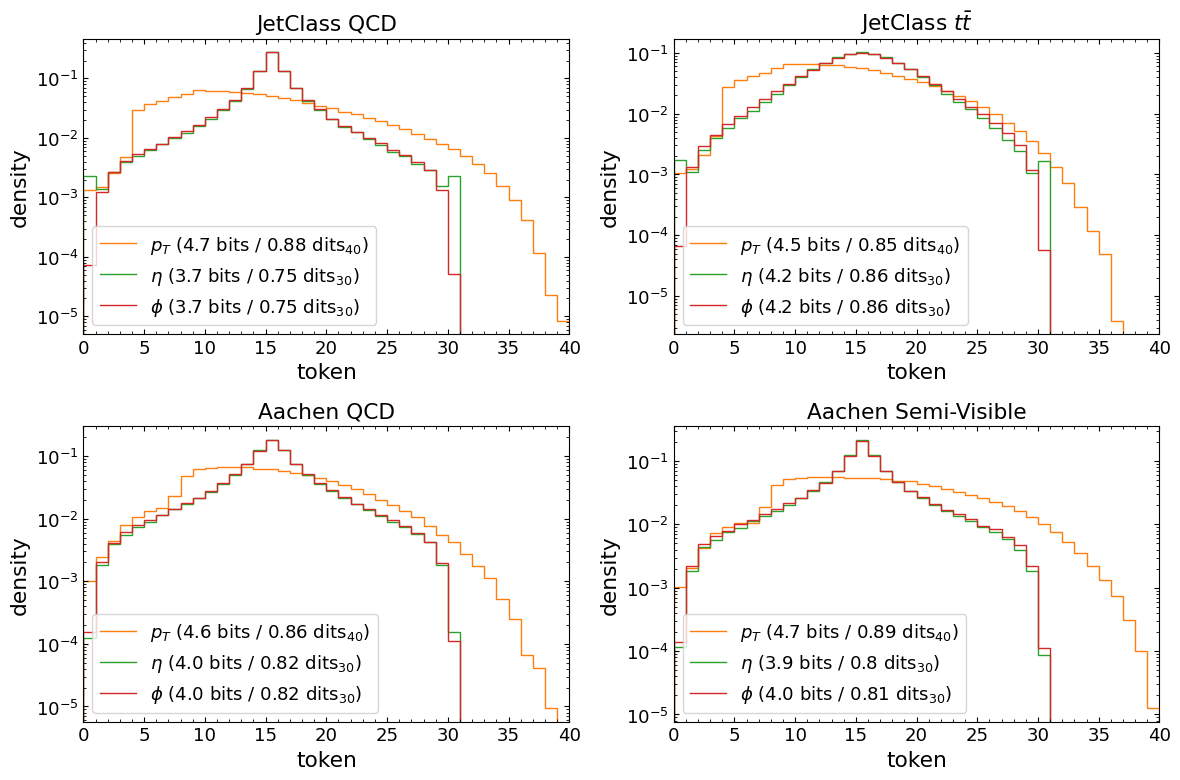

In [3]:
from namespace import *

@plot
def plot_token_distribution(path, stop=100000, loader=load_data):
    data = loader(path,stop)
    N = 40
    for i, label in enumerate(["$p_T$","$\\eta$","$\\phi$"]):
        p,bins = np.histogram(data[i], np.linspace(0,N,N+1), density=True)
        p_ = p[p!=0]
        S = np.sum(-p_*log(p_))
        dit =  len(data[i+3])
        plt.stairs(p, bins, color=f"C{i+1}", alpha=1, label=label+f" ({S/log(2):.2} bits / {S/log(dit):.2} dits${{}}_{{{dit}}}$)")
    plt.legend()
    plt.xlim(0,40)
    plt.xlabel("token")
    plt.ylabel("density")
    plt.yscale("log")

fig, axes = plt.subplots(2,2,figsize=(12,8)) # 9,7
# fig.suptitle(bf("Token Distribution and Entropy"), fontsize=13)

for ax,path,title in zip(flat(axes), 
                         paths[["z/train", "ttbar/train", "qcd/train", "aachen/train"]],
                         [r"JetClass QCD", "JetClass $t\\bar t$", "Aachen QCD", "Aachen Semi-Visible"]):
    plot_token_distribution(path, 10_000, load_data2, ax=ax, title=title, show=False, close=False)

# plt.savefig(plots_path+"token_distribution_and_entropy.pdf")
    

### unbinned angular distributions

/tmp/ipykernel_680097/3228526828.py:18: RuntimeWarning: invalid value encountered in divide
  eta = 1/2 * np.log((E + p_z) / (E - p_z))
/tmp/ipykernel_680097/3228526828.py:18: RuntimeWarning: invalid value encountered in divide
  eta = 1/2 * np.log((E + p_z) / (E - p_z))


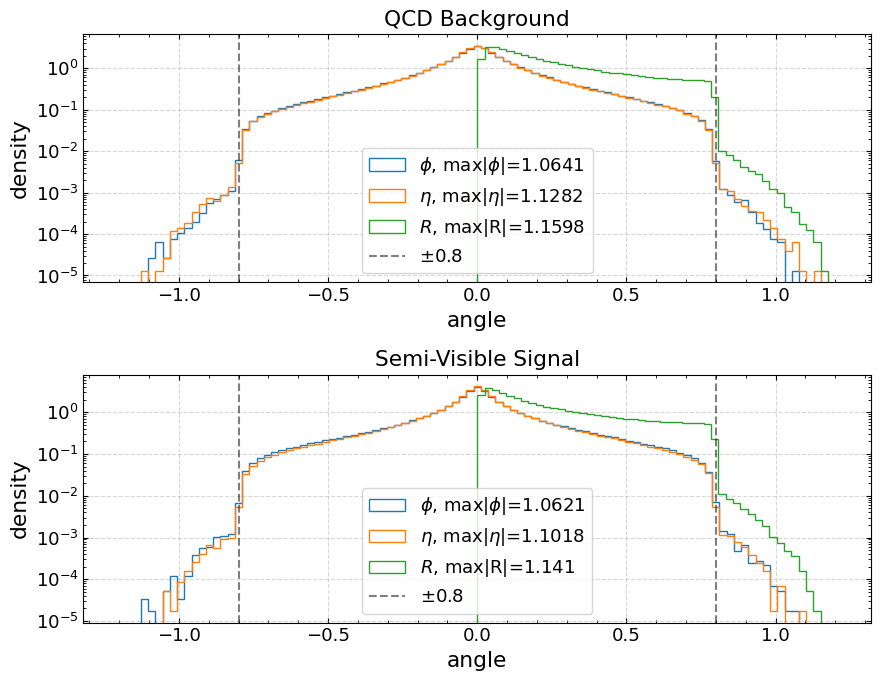

In [4]:
from namespace import *

@plot
def plot_unbinned_dist(path, N=100_000, print_outliers=True):
    bins = np.linspace(-1.2, 1.2, 100)

    data = np.asarray(pd.read_hdf(path, key="table", stop=N))
    E, p_x, p_y, p_z = data[:,:-1:4], data[:,1::4], data[:,2::4], data[:,3::4]

    mask = E==0
    def nanify(x):
        x[mask] = np.nan 
        return x
        
    def f(E, p_x, p_y, p_z):
        p_T = np.sqrt(p_x**2 + p_y**2)
        phi = np.arctan2(p_y, p_x)
        eta = 1/2 * np.log((E + p_z) / (E - p_z))
        return p_T, phi, eta

    _, tot_phi, tot_eta = f(E.sum(1), p_x.sum(1), p_y.sum(1), p_z.sum(1))
    p_T, phi, eta = f(E, p_x, p_y, p_z)

    Delta_phi = (tot_phi[...,np.newaxis] - phi + np.pi) % (2*np.pi) - np.pi
    Delta_eta = tot_eta[...,np.newaxis] - eta 

    Delta_phi = nanify(Delta_phi)
    Delta_eta = nanify(Delta_eta)
    Delta = sqrt(Delta_phi**2 + Delta_eta**2)

    # index = np.nanargmax(np.nanmax(Delta_phi,axis=1))
    # print(Delta_phi[index][:50])

    plt.hist((Delta_phi).flatten(), bins, label=rf"$\phi$, max$|\phi|$={np.nanmax(Delta_phi):.5}", histtype="step", density=True)

    plt.hist((Delta_eta).flatten(), bins, label=rf"$\eta$, max$|\eta|$={np.nanmax(Delta_eta):.5}", histtype="step", density=True)
    
    plt.hist(Delta.flatten(), np.linspace(0, 1.2, 50), label=rf"$R$, max$|$R$|$={np.nanmax(Delta):.5}", histtype="step", density=True)

    plt.axvline(-0.8, ls="--", c="k", alpha=0.5, label="$\pm 0.8$")
    plt.axvline(0.8, ls="--", c="k", alpha=0.5)

    plotter(legend=True, grid=1, yscale="log", xlabel="angle", ylabel="density")
    
fig, axes = plt.subplots(2, 1, figsize=(9,7))
# fig.suptitle(bf("Angular Distributions - Prebinning"), fontsize=13)
    
plot_unbinned_dist(r"/net/data_ttk/hreyes/Semi-Visible/semivisible-jets/qcd/constitutents/qcd_constit.h5", title="QCD Background", ax=axes[0])

plot_unbinned_dist(r"/net/data_ttk/hreyes/Semi-Visible/semivisible-jets/aachen/constitutents/aachen_constit.h5", title="Semi-Visible Signal", ax=axes[1])

# fig.savefig(plots_path + "aachen_raw_angular_dist.pdf")

/tmp/ipykernel_680097/228754380.py:18: RuntimeWarning: invalid value encountered in divide
  eta = 1/2 * np.log((E + p_z) / (E - p_z))
/tmp/ipykernel_680097/228754380.py:18: RuntimeWarning: invalid value encountered in divide
  eta = 1/2 * np.log((E + p_z) / (E - p_z))


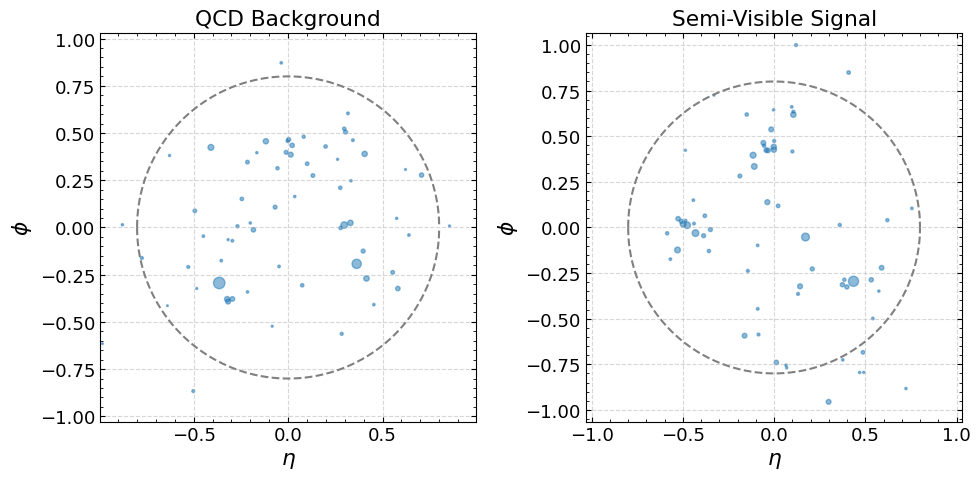

In [5]:
from namespace import *

@plot
def plot_outliers(path, N=100_000):
    bins = np.linspace(-1.2, 1.2, 100)

    data = np.asarray(pd.read_hdf(path, key="table", stop=N))
    E, p_x, p_y, p_z = data[:,:-1:4], data[:,1::4], data[:,2::4], data[:,3::4]

    mask = E==0
    def nanify(x):
        x[mask] = np.nan 
        return x
        
    def f(E, p_x, p_y, p_z):
        p_T = np.sqrt(p_x**2 + p_y**2)
        phi = np.arctan2(p_y, p_x)
        eta = 1/2 * np.log((E + p_z) / (E - p_z))
        return p_T, phi, eta

    _, tot_phi, tot_eta = f(E.sum(1), p_x.sum(1), p_y.sum(1), p_z.sum(1))
    p_T, phi, eta = f(E, p_x, p_y, p_z)

    Delta_phi = (tot_phi[...,np.newaxis] - phi + np.pi) % (2*np.pi) - np.pi
    Delta_eta = tot_eta[...,np.newaxis] - eta 

    Delta_phi = nanify(Delta_phi)
    Delta_eta = nanify(Delta_eta)

    Delta = np.sqrt(Delta_eta**2 + Delta_phi**2)
    idx = np.nanargmax(Delta.flat)
    idx = int(np.floor(idx / 200))
    PT, ETA, PHI = p_T[idx], Delta_eta[idx], Delta_phi[idx]
    
    plt.scatter(ETA, PHI, 1+2*PT, alpha=0.5)
    
    x = np.linspace(-0.8,0.8,1000)
    plt.plot(x, sqrt(0.8**2 - x**2), c="gray", ls="--")
    plt.plot(x, -sqrt(0.8**2 - x**2), c="gray", ls="--")
    plt.axis("equal")
    plotter(grid=True, xlim=(-1.1, 1.1), ylim=(-1.1, 1.1),
            xlabel=r"$\eta$", ylabel=r"$\phi$")
    
    return PT, ETA, PHI
    
fig, axes = plt.subplots(1, 2, figsize=(10,5))
    
PT1, ETA1, PHI1 = plot_outliers(r"/net/data_ttk/hreyes/Semi-Visible/semivisible-jets/qcd/constitutents/qcd_constit.h5", title="QCD Background", ax=axes[0])

PT2, ETA2, PHI2 = plot_outliers(r"/net/data_ttk/hreyes/Semi-Visible/semivisible-jets/aachen/constitutents/aachen_constit.h5", title="Semi-Visible Signal", ax=axes[1])

plt.tight_layout()
# fig.savefig(plots_path + "outliers_aachen.pdf")

In [ ]:
from namespace import *

def anti_kt_gif(pt, eta, phi, R=0.8, plot_each_merge=False, filename="anti-kt"):
    def deltaR(p1, p2):
        dphi = abs(p1['phi'] - p2['phi'])
        if dphi > pi:
            dphi = 2 * pi - dphi
        return sqrt((p1['eta'] - p2['eta'])**2 + dphi**2)

    def to_four_vector(p):
        px = p['pt'] * cos(p['phi'])
        py = p['pt'] * sin(p['phi'])
        pz = p['pt'] * sinh(p['eta'])
        E  = p['pt'] * cosh(p['eta'])
        return np.array([E, px, py, pz])

    def from_four_vector(four):
        E, px, py, pz = four
        pt = sqrt(px**2 + py**2)
        eta = 0.5 * log((E + pz) / (E - pz)) if E != abs(pz) else 0.0
        phi = np.arctan2(py, px)
        return {'pt': pt, 'eta': eta, 'phi': phi, 'index': -1}

    gif_frames = []
    def plot_merge(particles, i, j, new_jet, step):
        fig, ax = plt.subplots(figsize=(6, 6))
        etas = [p['eta'] for p in particles]
        phis = [p['phi'] for p in particles]
        pts = [p['pt'] for p in particles]
        plt.scatter(etas, phis, 1+2*np.array(pts),  label='Remaining particles', color='gray', alpha=0.4)

        for idx, color in zip([i, j], ['red', 'blue']):
            plt.scatter(particles[idx]['eta'], particles[idx]['phi'],  1+2*particles[idx]['pt'], color=color, label=f"Merging {idx}")

        plt.scatter(new_jet['eta'], new_jet['phi'], 1+2*new_jet['pt'], color='green', label='New Jet', marker='*')
        
        plt.plot(x:=np.linspace(-0.8,0.8,1000), np.sqrt(R**2 - x**2), 
                 ls="--", alpha=0.5, c="k")
        plt.plot(np.linspace(-0.8,0.8,1000), -np.sqrt(R**2 - x**2), 
                 ls="--", alpha=0.5, c="k")

        plotter(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1), grid=1,
                xlabel=r"$\eta$", ylabel=r"$\phi$", 
                title=f"Merge Step {step+1}")
        plt.tight_layout()
        
        buf = BytesIO()
        fig.savefig(buf, format='png', bbox_inches="tight")
        buf.seek(0)
        gif_frames.append(imageio.imread(buf))
        buf.close()
        plt.close(fig)

    particles = [{'pt': pt[i], 'eta': eta[i], 'phi': phi[i], 'index': i} for i in range(len(pt))]
    jets = []
    step = 0

    while particles:
        d_ij_list = []
        for i in range(len(particles)):
            for j in range(i + 1, len(particles)):
                dij = min(particles[i]['pt']**-2, particles[j]['pt']**-2) * deltaR(particles[i], particles[j])**2 / R**2
                d_ij_list.append((dij, i, j))

        d_iB_list = [(p['pt']**-2, i) for i, p in enumerate(particles)]

        min_dij = min(d_ij_list, default=(float('inf'), None, None))
        min_diB = min(d_iB_list, default=(float('inf'), None))

        if min_dij[0] < min_diB[0]:
            i, j = min_dij[1], min_dij[2]
            p1, p2 = particles[i], particles[j]
            f1 = to_four_vector(p1)
            f2 = to_four_vector(p2)
            merged = from_four_vector(f1 + f2)

            if plot_each_merge:
                plot_merge(particles, i, j, merged, step)

            # Entferne i, j (wichtig: höhere Indices zuerst)
            for idx in sorted([i, j], reverse=True):
                particles.pop(idx)
            particles.append(merged)
            step += 1
        else:
            jets.append(particles.pop(min_diB[1]))

    imageio.mimsave(plots_path + filename + ".gif", gif_frames, fps=2, loop=0)
    return jets

mask = np.isfinite(ETA1)
anti_kt_gif(PT1[mask], ETA1[mask], PHI1[mask], 
            plot_each_merge=True, filename="anti-kt1")

mask = np.isfinite(ETA2)
anti_kt_gif(PT2[mask], ETA2[mask], PHI2[mask], 
            plot_each_merge=True, filename="anti-kt2")

[{'pt': 243.7180123634592,
  'eta': -0.0001760825663704151,
  'phi': -2.9154297167845783e-16,
  'index': -1}]

## Generative Models
### comparison between data and samples

(100000, 200)
(100000, 128)


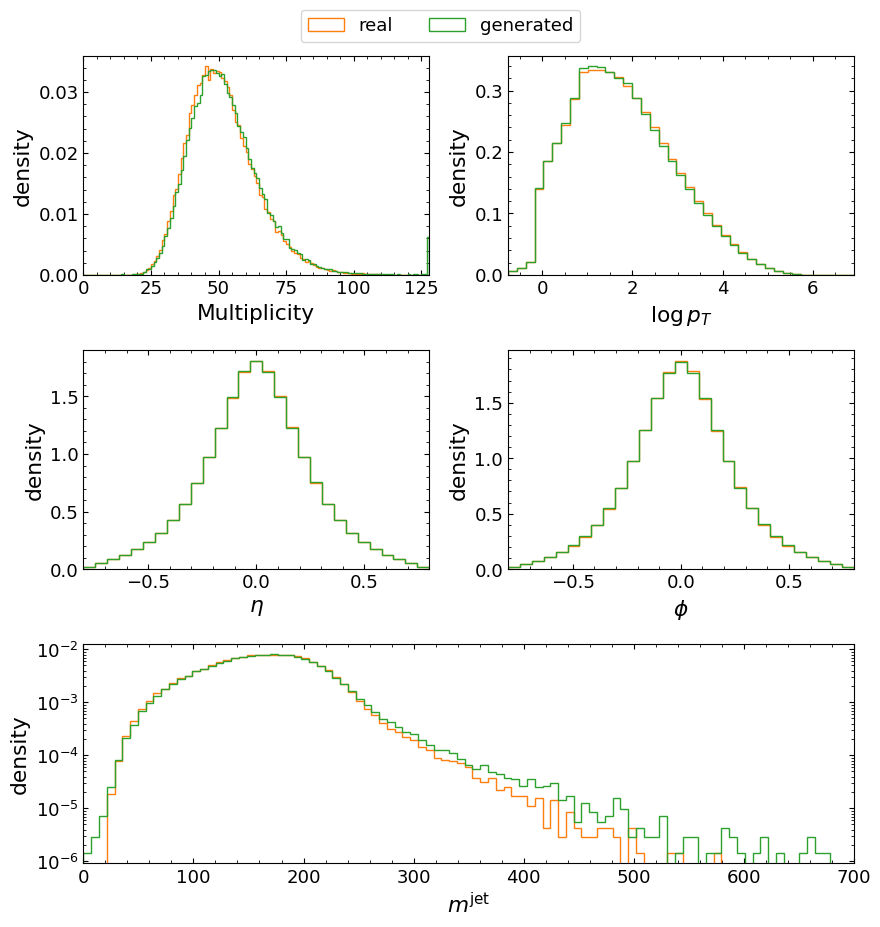

(100000, 200)
(100000, 128)


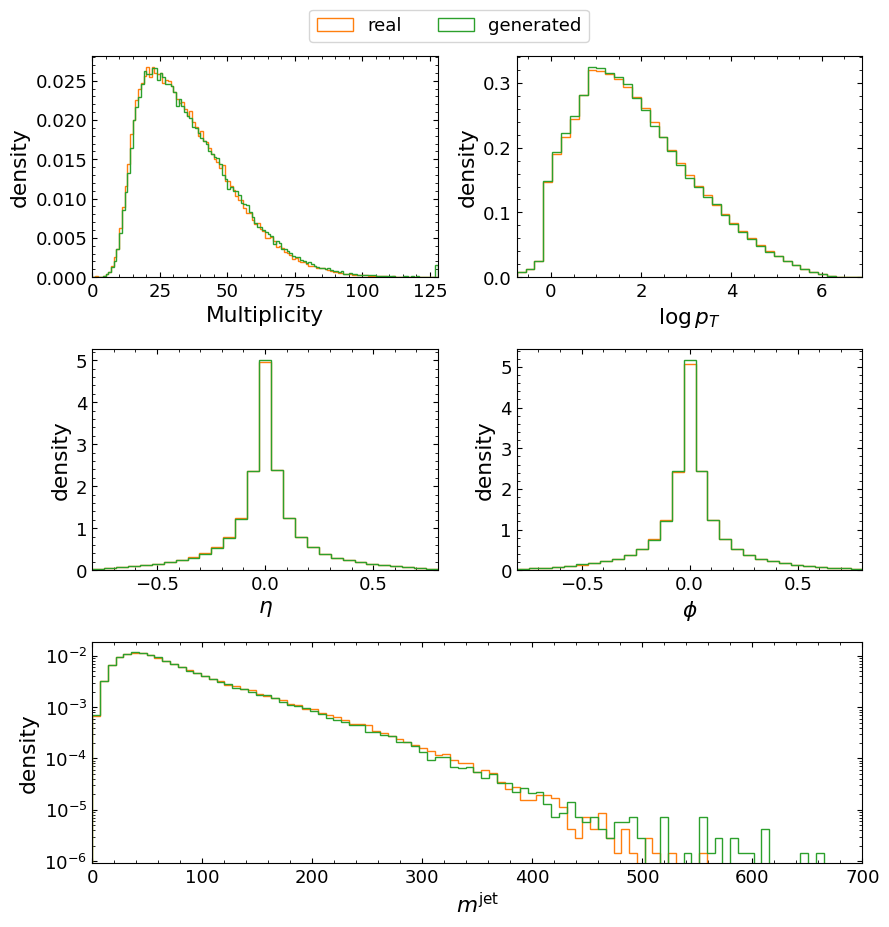

In [ ]:
from namespace import *

@plot
def plot_comparison(data_path, samples_path, title=None, N=100_000, loader=load_data2, p_T_xlim=700):
    fig, axes = plt.subplot_mosaic("AB\nCD\nEE", figsize=(9,9), height_ratios=[1,1,1])
    axes = list(axes.values())
    
    for i,path in enumerate([data_path, samples_path]):
        p_T, phi, eta, bins_p_T, bins_phi, bins_eta = loader(path, N)
        p_T, phi, eta = bins2values(p_T, bins_p_T), bins2values(phi, bins_phi), bins2values(eta, bins_eta)
        print(np.shape(phi))
        
        M = np.isfinite(p_T).sum(1)
        p_x, p_y, p_z = p_T*cos(phi), p_T*sin(phi), p_T*sinh(phi)
        E = np.abs(p_T*cosh(phi))
        m = np.sqrt(np.maximum(np.nansum(E,1)**2 - np.nansum(p_x,1)**2 - np.nansum(p_y,1)**2 - np.nansum(p_z,1)**2, 0))
        
        bins = [np.arange(128), 
                np.log(bins_p_T), 
                bins_eta, 
                bins_phi, 
                np.linspace(0,p_T_xlim,100)]
        
        for j,x in enumerate([M, log(p_T), eta, phi, m]):
            x = x[np.isfinite(x)]
            
            if j==0: # add overflow bin for multiplicity distribution
                delta = np.mean(np.diff(bins[j]))
                bins_ = [*bins[j], np.inf]
                values, bins_ = np.histogram(x, bins_, density=False)
                bins_ = [*bins_[:-1], bins_[-2]+delta]
            else: 
                values, bins_ = np.histogram(x, bins[j], density=True)
            
            axes[j].hist(bins_[:-1], bins=bins_, weights=values, density=True, 
                         color=f"C{i+1}", alpha=1, histtype="step", 
                         label=None if j!=0 else ("real" if i==0 else "generated"),)
            axes[j].set_xlim(bins_[0], bins_[-1])
            

    xlabels = ["Multiplicity", "$\log p_T$", r"$\eta$", r"$\phi$", r"$m^{\text{jet}}$", ""]
    for i in range(len(axes)): 
        axes[i].set_xlabel(xlabels[i])
        axes[i].set_ylabel("density")
    
    axes[4].set_yscale("log")
    
    fig.legend(ncols=2, loc="upper center", bbox_to_anchor=(0.5, 1.04))

# TTBar 10m 20e
plot_comparison(paths["ttbar/test"], 
                r"/net/data_ttk/lcordes/TTBar_10m_20e/samples_128c_100k.h5",
                r"Real vs. Generated Samples ($\mathbf{t\bar t}$)",
                savefig="data_vs_gen_ttbar.pdf")

# ZToNuNu 10m 20e
plot_comparison(paths["z/test"], 
                r"/net/data_ttk/lcordes/ZToNuNu_10m_20e/samples_128c_100k.h5", 
                savefig="data_vs_gen_qcd.pdf")

# # Aachen 10m 202
# plot_comparison(paths["aachen/test"], 
#                 r"/net/data_ttk/lcordes/Aachen_200k_20_30e/samples_samples_100k.h5", 
#                 "Aachen Data vs. Samples")

# # QCD
# plot_comparison(paths["qcd/test"], 
#                 r"/net/data_ttk/lcordes/QCD_300k_20_30e/samples_100k.h5", 
#                 "QCD Data vs. Samples")

### density estimation

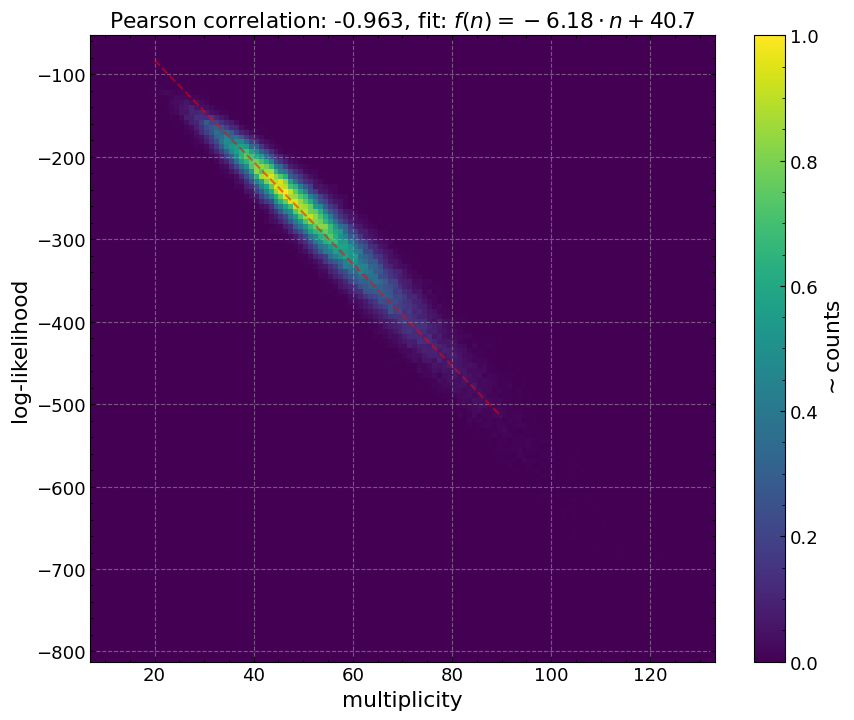

In [ ]:
from namespace import *

@plot
def plot_probability_distribution(filename, gauss=True, interp=True, savefig=None):
    data = np.load(filename)
    probs = data.get("probs")
    n_const = data.get("n_const")
    # fit = np.polyfit(n_const, probs, deg=1)
    fit = odr(n_const, probs, [-5.73, 17.7])
    
    xlim = np.array((min(n_const), max(n_const))).astype(float)
    xlim = (xlim + .08 * np.diff(xlim) * [-1,1]).astype(int)
    ylim = np.array((min(probs), max(probs))).astype(float)
    ylim += .08* np.diff(ylim) * [-1,1]
    
    z, xe, ye = np.histogram2d(n_const, probs, (np.linspace(*xlim, int(np.diff(xlim)[0]+1)),
                                                np.linspace(*ylim, int(np.diff(xlim)[0]+1))))
    if gauss: z = scipy.ndimage.gaussian_filter(z, sigma=2, truncate=3,)
    if interp: z = scipy.ndimage.zoom(z, 5, order=3,)
    
    # z = np.sqrt(np.clip(z/np.max(z), 0, np.inf))
    z = np.clip(z/np.max(z), 0, np.inf)
    
    plt.imshow(z.T[::-1,::], extent=(*xlim, *ylim), aspect="auto")
    
    plt.title(f"Pearson correlation: {np.corrcoef(probs,n_const)[0][1]:.3}, fit: $f(n)={fit[0]:.3}\\cdot n + {fit[1]:.3}$")
    plt.colorbar(label=fr"$\sim\text{{{'density' if interp else 'counts'}}}$")
    plt.xlabel("multiplicity")
    plt.ylabel("log-likelihood")
    plt.grid(ls="--", alpha=0.5)
    plt.gcf().set_size_inches((9,7.4))
    
    plt.plot(x:=np.linspace(20,90,1000), np.poly1d(fit)(x), ls="--", c="r", alpha=0.5)
    
    if savefig: plt.savefig(savefig)

plot_probability_distribution("/net/data_ttk/lcordes/TTBar_10m_20e/results_100k.npz",
                              savefig="TTBar_density_estimation.pdf", gauss=False, interp=False)

## Classifiers
### Activations and ROC 

                   <Classifier Performaces>                   
╭──────────────────┬───────────┬─────────┬───────────────────╮
│ Classifier       │   Acc [%] │     AUC │   1/ϵ_B (ϵ_S=0.3) │
├──────────────────┼───────────┼─────────┼───────────────────┤
│ Aachen           │     79.54 │ 0.86595 │              87.2 │
│ Aachen Backb.    │     79.84 │ 0.87056 │              94.1 │
│ Aachen Backb. +e │     80.06 │ 0.87102 │              92.7 │
│ TTBar            │     93.48 │ 0.98225 │             644.3 │
│ TTBar Backb.     │     93.52 │ 0.98242 │             711.2 │
╰──────────────────┴───────────┴─────────┴───────────────────╯


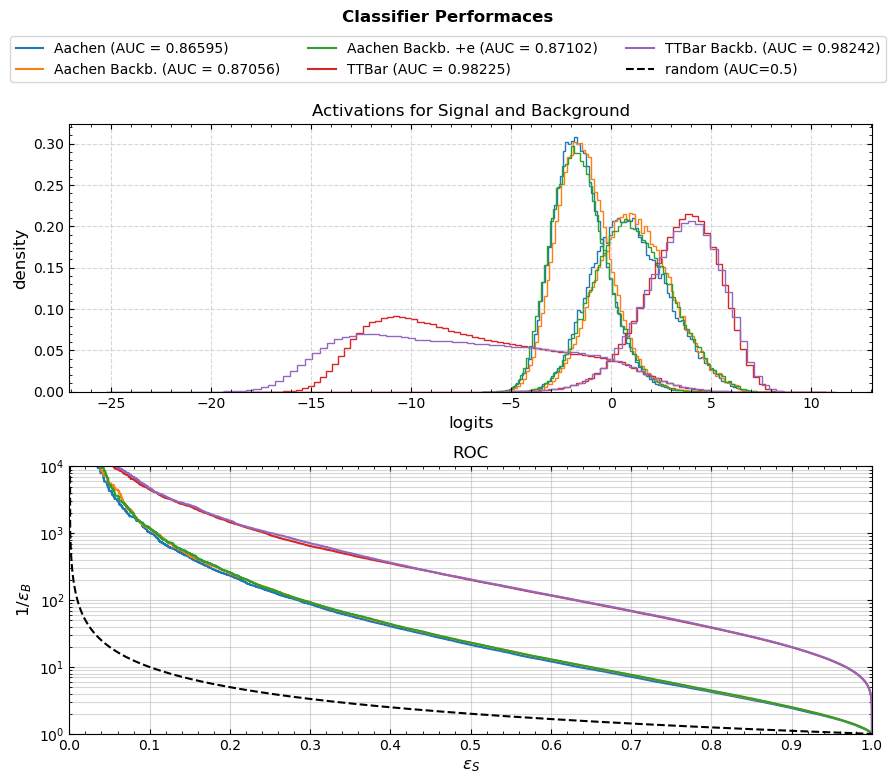

In [ ]:
from namespace import *

@plot
def plot_preds(paths, labels):
    for i, [path, label] in enumerate(zip(np.atleast_1d(paths), np.atleast_1d(labels))):
        data = np.load(path)
        logits = (data["logits"]).flatten()
        labels = data["labels"].flatten().astype(bool)
    
        bins = np.linspace(*lim(logits), 100)
        for logits in [logits[labels], logits[~labels]]:
            values, bins = np.histogram(logits, bins, density=True)
            plt.stairs(values, bins, color=f"C{i}")
        
    plotter(grid=1, xlabel="logits", ylabel="density")

@plot 
def plot_roc(filenames, labels, linear=False, switch=False, signal_eff=0.3):
    filenames, labels = np.array(filenames, ndmin=1), np.array(labels, ndmin=1)
    
    aucs, bg_rejection, accuracy = [], [], []
    for filename, label in zip(filenames, labels):
        data = np.load(filename)
        preds = (data["predictions"]).flatten()
        labels = data["labels"].flatten().astype(bool) ^ switch 
        accuracy.append(1 - np.abs(np.round(preds) - labels).sum() / len(labels))

        fpr, tpr, _ = sklearn.metrics.roc_curve(labels, preds)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        
        aucs.append(roc_auc)
        bg_rejection.append(1/fpr[np.argmin(np.abs(tpr - signal_eff))])

        plt.plot(tpr, fpr if linear else 1/fpr, label=f"{label} (AUC = {roc_auc:.5f})")
        
    if linear:
        plt.plot(x:=[0,1], x, 'k--', label="random (AUC=0.5)")
        plotter(ylabel=r"$\epsilon_B$", grid=1, ylim=(0,1))
    else:
        plt.plot(x:=np.linspace(1e-7,1,1000), 1/x, 'k--', label="random (AUC=0.5)")
        plt.grid(axis="y",which="both", ls="-", alpha=0.5)
        plt.grid(axis="x", ls="-", alpha=0.5)
        plotter(ylabel=r"$1/\epsilon_B$", ylim=(1,1e4), yscale="log")
        
    plt.xticks(np.linspace(0,1,11))
    plotter(xlabel=r"$\epsilon_S$", xlim=[0,1])
    
    return np.array(aucs), np.array(bg_rejection), np.array(accuracy)

def plot_classifiers(filenames, labels, switch=False, ncol=3, title="Classifier Performaces", sort_by_col=False, reverse_sort=True):
    idx = np.argsort(labels)
    filenames = np.array(filenames)[idx]
    labels = np.array(labels)[idx]
    fig, ax = plt.subplots(2, 1, figsize=(9, 7))

    plot_preds(filenames, labels, title=r"Activations for Signal and Background", ax=ax[0])
    aucs, bg_rejection, accuracy = plot_roc(filenames, labels, title=r"ROC", switch=switch, ax=ax[1])

    leg = fig.legend(loc="lower center", bbox_to_anchor=(0.5, 1), ncol=ncol)

    fig.canvas.draw()
    bbox = leg.get_window_extent()
    bbox_fig = fig.transFigure.inverted().transform(bbox)
    top_of_legend = bbox_fig[1, 1]

    fig.text(0.5, top_of_legend + 0.02, title,
             ha="center", fontsize=12, fontweight="bold")

    table([labels, 100*accuracy, aucs, bg_rejection],
          ["Classifier", "Acc [\%]", "AUC", r"$1/\epsilon_B (\epsilon_S=0.3)$"],
          fmt=[None, ".2f", ".5f", ".1f"], caption=title, sort_by_col=sort_by_col, reverse_sort=reverse_sort)
    
filenames = [r"/net/data_ttk/lcordes/TTBar_ZToNuNu_classifier_1m_10e/predictions_1m.npz",
             r"/net/data_ttk/lcordes/TTBar_ZToNuNu_classifier_from_backbone_1m_10e/predictions_1m.npz",
             r"/net/data_ttk/lcordes/QCD_Aachen_classifier_1m_10e/predictions_1m.npz",
             r"/net/data_ttk/lcordes/QCD_Aachen_classifier_from_QCD_backbone_1m_10e/predictions_1m.npz",
             r"/net/data_ttk/lcordes/QCD_Aachen_classifier_from_QCD_backbone_1m_10e_d/predictions_1m.npz"]

labels = ["TTBar",
          "TTBar Backb.",
          "Aachen",
          "Aachen Backb.",
          "Aachen Backb. +e"]

plot_classifiers(filenames, labels, switch=True)

                                       <Classifier Performaces>                                        
╭──────────────────────────────────┬───────────┬─────────┬───────────────────┬──────────────┬─────────╮
│ Classifier                       │   Acc [%] │     AUC │   1/ϵ_B (ϵ_S=0.3) │ Step/Epoch   │   Preds │
├──────────────────────────────────┼───────────┼─────────┼───────────────────┼──────────────┼─────────┤
│ TTBar_Backbone/Linear_Freeze_2   │     78.79 │ 0.86989 │              86.3 │ 34983/9      │   64784 │
│ TTBar_Backbone/CLSToken_Freeze_2 │     78.69 │ 0.8686  │              85.2 │ 34983/9      │   64784 │
│ TTBar_Backbone/MeanPool_Freeze_2 │     78.68 │ 0.86782 │              80.7 │ 34983/9      │   64784 │
│ TTBar_Backbone/AttnPool_Freeze_2 │     78.38 │ 0.86476 │              73.6 │ 38870/10     │   64784 │
│ TTBar_Backbone/MaxPool_Freeze_2  │     61.36 │ 0.83631 │              47   │ 3887/1       │   64784 │
╰──────────────────────────────────┴───────────┴─────────┴──────

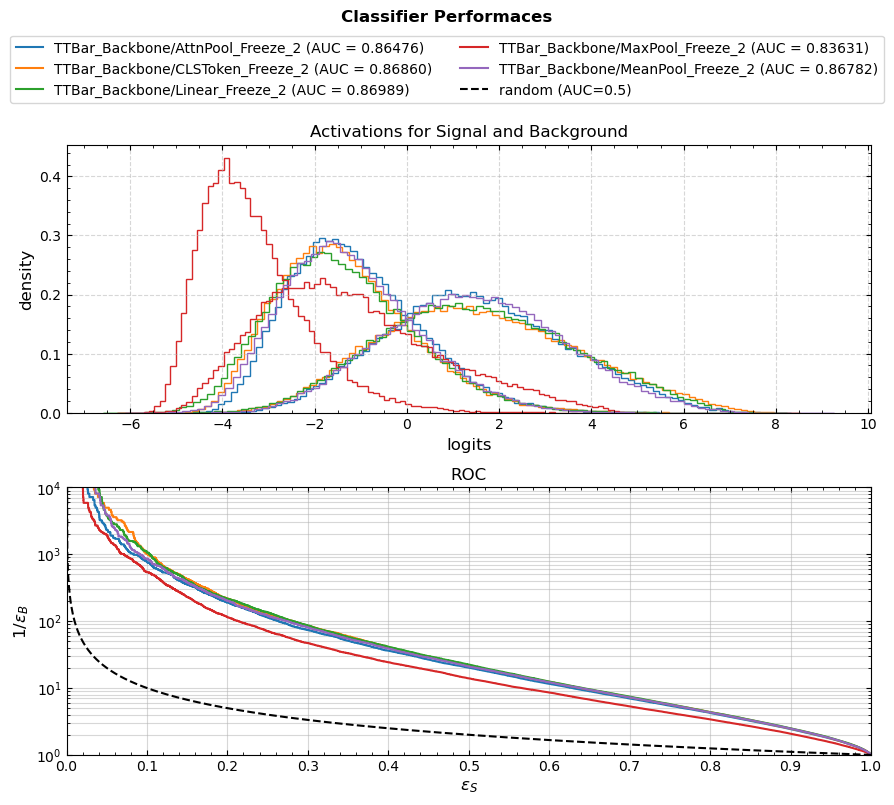

In [ ]:
from namespace import *

@plot
def plot_preds(paths, labels):
    for i, [path, label] in enumerate(zip(np.atleast_1d(paths), np.atleast_1d(labels))):
        data = np.load(path)
        logits = (data["logits"]).flatten()
        labels = data["labels"].flatten().astype(bool)
        
        bins = np.linspace(*lim(logits), 100)
        for logits in [logits[labels], logits[~labels]]:
            values, bins = np.histogram(logits, bins, density=True)
            plt.stairs(values, bins, color=f"C{i}")
        
    plotter(grid=1, xlabel="logits", ylabel="density")

@plot 
def plot_roc(filenames, labels, linear=False, switch=False, signal_eff=0.3):
    filenames, labels = np.array(filenames, ndmin=1), np.array(labels, ndmin=1)
    
    aucs, bg_rejection, accuracy = [], [], []
    for filename, label in zip(filenames, labels):
        data = np.load(filename)
        preds = (data["predictions"]).flatten()
        labels = data["labels"].flatten().astype(bool) ^ switch 
        # accuracy.append(1 - np.abs(np.round(preds) - labels).sum() / len(labels))
        accuracy.append(1 - np.abs(np.round(preds) - labels).sum() / len(labels))

        fpr, tpr, _ = sklearn.metrics.roc_curve(labels, preds)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        
        aucs.append(roc_auc)
        bg_rejection.append(1/fpr[np.argmin(np.abs(tpr - signal_eff))])

        plt.plot(tpr, fpr if linear else 1/fpr, label=f"{label} (AUC = {roc_auc:.5f})")
        
    if linear:
        plt.plot(x:=[0,1], x, 'k--', label="random (AUC=0.5)")
        plotter(ylabel=r"$\epsilon_B$", grid=1, ylim=(0,1))
    else:
        plt.plot(x:=np.linspace(1e-7,1,1000), 1/x, 'k--', label="random (AUC=0.5)")
        plt.grid(axis="y",which="both", ls="-", alpha=0.5)
        plt.grid(axis="x", ls="-", alpha=0.5)
        plotter(ylabel=r"$1/\epsilon_B$", ylim=(1,1e4), yscale="log")
        
    plt.xticks(np.linspace(0,1,11))
    plotter(xlabel=r"$\epsilon_S$", xlim=[0,1])
    
    return np.array(aucs), np.array(bg_rejection), np.array(accuracy)

def plot_classifiers(filenames, labels, switch=False, ncol=3, title="Classifier Performaces", sort_by_col=False, reverse_sort=True):
    idx = np.argsort(labels)
    filenames = np.array(filenames)[idx]
    labels = np.array(labels)[idx]
    fig, ax = plt.subplots(2, 1, figsize=(9, 7))

    plot_preds(filenames, labels, title=r"Activations for Signal and Background", ax=ax[0])
    aucs, bg_rejection, accuracy = plot_roc(filenames, labels, title=r"ROC", switch=switch, ax=ax[1])

    leg = fig.legend(loc="lower center", bbox_to_anchor=(0.5, 1), ncol=ncol)

    fig.canvas.draw()
    bbox = leg.get_window_extent()
    bbox_fig = fig.transFigure.inverted().transform(bbox)
    top_of_legend = bbox_fig[1, 1]

    fig.text(0.5, top_of_legend + 0.02, title,
             ha="center", fontsize=12, fontweight="bold")
    
    table([labels, 100*accuracy, aucs, bg_rejection, 
           [Path(x).parent.name.replace("_", "/") for x in filenames],
           [Path(x).name.removeprefix("predictions_").removesuffix(".npz") for x in filenames]],
          ["Classifier", "Acc [\%]", "AUC", r"$1/\epsilon_B (\epsilon_S=0.3)$", "Step/Epoch", "Preds"],
          fmt=[None, ".2f", ".5f", ".1f", None, None], caption=title, sort_by_col=sort_by_col, reverse_sort=reverse_sort)
    
def plot_all_classifiers(pattern="", title="Classifier Performaces", src_dir=r"/net/data_ttk/lcordes/classifier_var_heads", sort_by_col=False, reverse_sort=True, which="best"):
    if which=="best":
        preds = [max(walk_dir(f"tests/{torch.load(x, 'cpu').global_step}.*npz", x.parent))
                  for x in walk_dir(pattern + r".*model_best\.pt$", src_dir)]
    elif which=="last":
        preds = [select_max(select_max(dir), "predictions") for dir 
                 in walk_dir(pattern + ".*tests$", src_dir) 
                 if any(os.listdir(dir))]
        
    
    labels = ["/".join(str(x).split("/")[-5:-3]) for x in preds]
    plot_classifiers(preds, labels, ncol=2, title=title, sort_by_col=sort_by_col, reverse_sort=True)

plot_all_classifiers("Freeze.*_2", sort_by_col=2, which="best", 
                     src_dir=r"/net/data_ttk/lcordes/test_heads_and_protocols/Aachen") 
# plot_all_classifiers("Aachen/Normal", sort_by_col=2, which="last") 

In [ ]:
def test_attention_pooling(model, num_events=100, batch_size=1, num_workers=0 , save_pdf=True):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"using device {device}")
    model.to(device)
    
    model.eval()
    test_loader = get_dataloader(model.bg_file, model.sig_file, num_events, model.num_const, batch_size, num_workers, train=False)
    
    labels, logits, predictions, attn_weights, N = [], [], [], [], []
    with torch.no_grad():
        for jet, padding, label in tqdm(test_loader, desc="testing"):
            jet, padding, label = jet.to(device), padding.to(device), label.to(device)
            
            logit = model(jet, padding)

            attn_weights.append(logit.attn_weights.cpu())
            logit = logit.squeeze(1)
            labels.append(label.cpu().numpy())
            logits.append(logit.cpu().numpy())
            predictions.append(torch.sigmoid(logit).cpu().numpy())
            N.append(128 - padding.sum(1))
    
    del test_loader
    
    path = model.dir / "tests" / f"{model.global_step}_{model.global_epoch}"
    path.mkdir(exist_ok=True)
    predictions_path = path / f"attentions_{num_events}"
    print(f"saving to: '{predictions_path}.npz'")
    
    np.savez(predictions_path, labels=labels, logits=logits, predictions=predictions, attn_weights=attn_weights, N=N)
    
# model = torch.load(r"/net/data_ttk/lcordes/classifier_var_heads/QCD_vs_Aachen/SimpleAttentionPoolHead/model_best.pt", "cpu")
# test_attention_pooling(model, 10000)
    
# model = torch.load(select_max_auc("Attn"), "cpu")
# test_attention_pooling(model, 10000)

using device cpu


testing:   0%|          | 0/20000 [00:00<?, ?it/s]

/home/home3/institut_thp/lcordes/gpu_env/miniconda/envs/main/lib/python3.9/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(


saving to: '/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/AttnPool_ReducedLR_2/tests/34983_9/attentions_10000.npz'


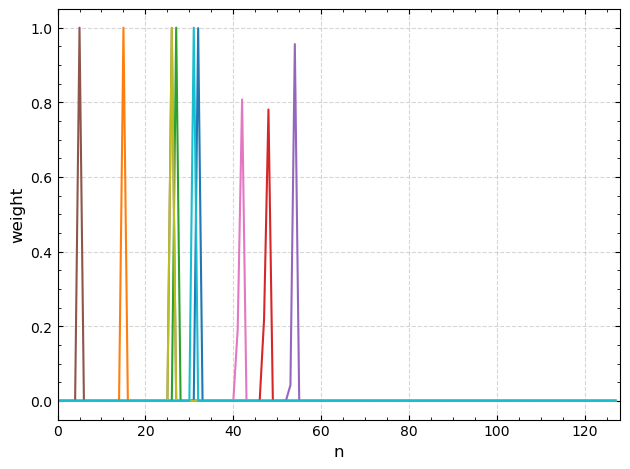

In [ ]:
def plot_attention_pooling(path, n=5, norm_x=True, norm_y=True, title="", savefig=None):
    data = np.load(path)
    
    logits = data["logits"].squeeze(1)
    labels = data["labels"].squeeze(1)
    predictions = data["predictions"].squeeze(1)
    attn_weights = data["attn_weights"].squeeze((1,3))
    N = data["N"].squeeze(1)
    
    x = np.array([np.arange(128) / (n-1 if norm_x else 1) for n in N])
    y = attn_weights / (np.max(attn_weights, axis=1)[:,None] if norm_y else 1)
    
    idx = np.arange(len(x)); np.random.shuffle(idx)
    x, y = x[idx], y[idx]
    
    for i in range(n):
        plt.plot(x[i], y[i])

    if norm_x: 
        plt.xlim(0,1)
        plt.xlabel("$n/N$")
    else:
        plt.xlabel("n")
        
    if norm_y: 
        plt.ylim(0,1)
        plt.ylabel(r"$w_n / \max\{w_i\}$")
    else:
        plt.ylabel("weight")
    
    plt.title(title, fontweight="bold")
    plotter(grid=True, xlim=(0,128))
    if savefig: plt.savefig(plots_path + savefig)


# plot_attention_pooling(r"/net/data_ttk/lcordes/classifier_var_heads/QCD_vs_Top/SimpleAttentionPoolHead/tests/160000_8/attentions_10000.npz",
#                        title="Top Attention Pooling Weights", 
#                        norm_x=False, norm_y=False, n=5)
# plt.show()

# plot_attention_pooling(r"/net/data_ttk/lcordes/classifier_var_heads/QCD_vs_Aachen/SimpleAttentionPoolHead/tests/38870_10/attentions_10000.npz",
#                        title="Semi-Visible Attention Pooling Weights", 
#                        norm_x=False, norm_y=False, n=5)

# plot_attention_pooling(r"/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/AttnPool_ReducedLR_2/tests/34983_9/attentions_10000.npz", 
#                        norm_x=False, norm_y=False, n=10,
#                        savefig="AttnPool_10_weight_dist.pdf")

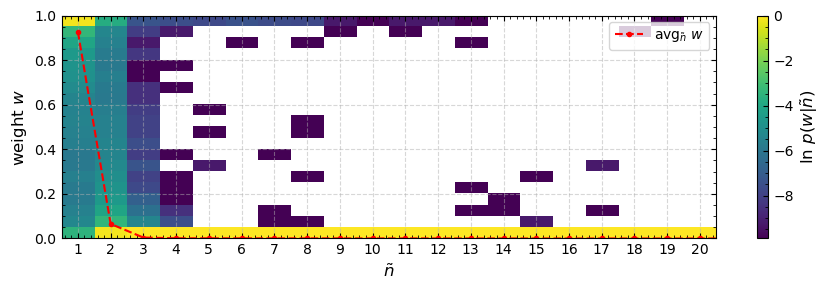

In [199]:
# reverse 

def plot_attention_pool_inv(path, savefig=None):
    plotter(figsize=(12/4*3,3), xlabel="$\\tilde n$", ylabel="weight $w$",
            xlim=(0.5,20.5), ylim=(0,1), grid=1)
    data = np.load(path)
    
    attn_weights = data["attn_weights"].squeeze((1,3)) # (N_jets, 128)
    N = data["N"].squeeze(1) # (N_jets)
    
    x = np.tile(np.arange(1,129), (len(N),1)) # (N_jets, 128)
    
    y = np.zeros_like(x, dtype=float)
    for i, [attn, n] in enumerate(zip(attn_weights, N)):
        y[i,:n] = attn[:n][::-1]

    plt.plot(np.arange(1,129), y.mean(0), 
             marker=".", c="r", ls="--", label="avg${}_{\\tilde n}$ $w$")
    
    # bg
    z, xe, ye = np.histogram2d(x.ravel(), y.ravel(), 
                               [np.linspace(0.5,128.5,129), np.linspace(0,1,21)], 
                               range=[[0,128], [0,1]],)

    mask = z==0
    sum_y = np.sum(z, axis=1, keepdims=True)
    z = np.log(np.divide(z, sum_y, where=sum_y!=0))
    z[mask] = np.nan
    
    plt.imshow(z.T[::-1,::], extent=(0.5,128.5, 0,1), aspect="auto",)
    cbar = plt.colorbar(label="ln $p(w|\\tilde n)$")

    plt.xticks(np.arange(1,21))

    plt.legend()
    plt.tight_layout()
    if savefig: plt.savefig(plots_path + savefig)


plot_attention_pool_inv(r"/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/AttnPool_ReducedLR_2/tests/34983_9/attentions_10000.npz", savefig="attn_pool_inv.pdf")

### Gradients

-2.106769323348999
5.018951892852783
-0.6833814382553101


/tmp/ipykernel_383001/1226304446.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=f"sig={int(label)}\nn={len(jet)}")


5.296853542327881


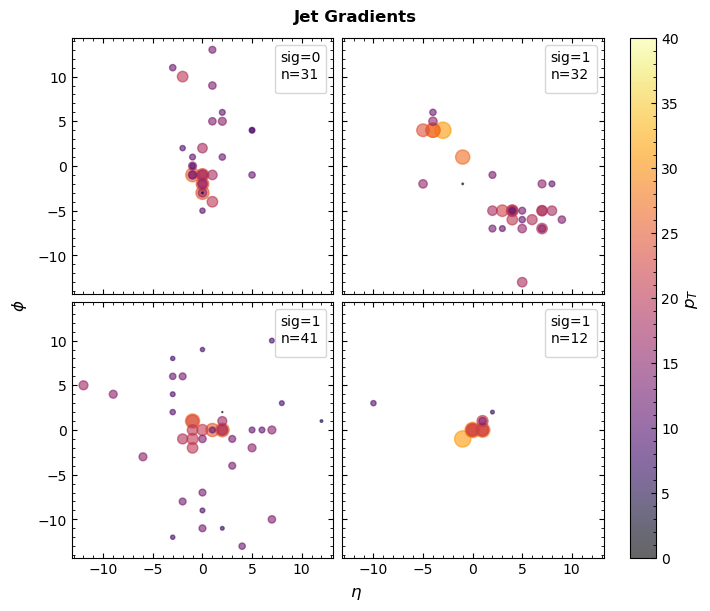

In [ ]:
from namespace import *

def plot_jets(model):
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(7,6), constrained_layout=True)
    axes = flat(axes)
    
    test_loader = list(get_dataloader(model.bg_file, model.sig_file, 50, model.num_const, 1, 0, train=False))
    np.random.shuffle(test_loader)
    for ax, [jet, padding, label] in zip(axes, test_loader):
        model.eval()
        y = float(model(jet, padding))
        print(y)
        
        jet, padding = jet[0], padding[0]
        jet = jet[~padding]
        jet[:,1:] -=15
        sc = ax.scatter(jet[:,1], jet[:,2], 
                        s=jet[:,0]**2/7, c=jet[:,0], 
                        cmap="inferno", vmin=0, vmax=40, 
                        alpha=.6)
        ax.legend(title=f"sig={int(label)}\nn={len(jet)}")
        
    cbar = fig.colorbar(sc, ax=axes)
    cbar.set_label(r"$p_T$")
    
    fig.supxlabel(r"$\eta$")
    fig.supylabel(r"$\phi$")
    fig.suptitle("Jet Gradients", fontweight="bold")
        

    
model = torch.load(r"/net/data_ttk/lcordes/classifier_var_heads/QCD_vs_Aachen/SimpleAttentionPoolHead/model_best.pt", "cpu")
plot_jets(model)
# [[pt1, eta1, phi1], [pt2, eta2, phi2], ...]
# grad eta2 = Model([[pt1, eta1, phi1], [pt2, eta2 + 1, phi2], ...]) - Model([[pt1, eta1, phi1], [pt2, eta2, phi2], ...])

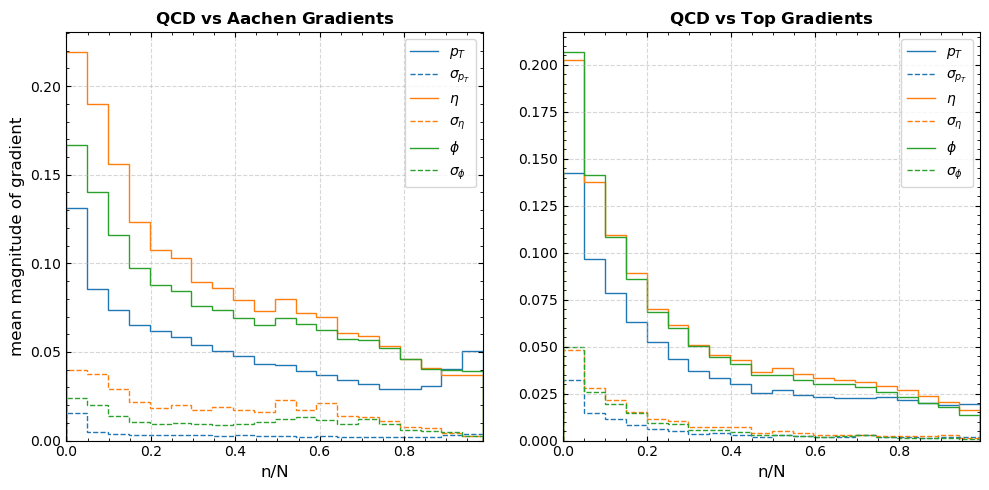

In [ ]:
from namespace import * 

# mean and std
@plot
def plot_jet_gradients_by_const(file, normalize=False, bins=20, single_event=False, show_total=True, show_std=False):
    data = np.load(file)
    
    jets = data["jets"]
    paddings = data["paddings"]
    labels = data["labels"]
    gradients = data["gradients"]
    
    N = (~paddings).sum(1) 
    N = np.array([np.arange(128)/(n if normalize else 1) for n in N])
    
    idx = np.random.randint(len(data["jets"])) if single_event else np.s_[:]
    if single_event:
        jets = np.array([jets[idx]])
        paddings = np.array([paddings[idx]])
        labels = np.array([labels[idx]])
        gradients = np.array([gradients[idx]])
        N = np.array([N[idx]])
    
    valid = ~paddings.ravel()
    N_flat = N.ravel()[valid]
    G_flat = np.abs(gradients).reshape(-1, 3)[valid]
    
    bin_edges = np.linspace(0, 1 if normalize else 128, bins + 1)
    total = np.zeros(bins)
    for j, label in enumerate(["p_T", r"\eta", r"\phi"]):
        grad_count, bin_edges = np.histogram(N_flat, bins=bins)
        grad_sum, _ = np.histogram(N_flat, bin_edges, weights=G_flat[...,j])
        grad_sq, _ = np.histogram(N_flat, bin_edges, weights=G_flat[...,j]**2)
        
        grad_avg = grad_sum / grad_count 
        grad_sq_avg = grad_sq / grad_count 
        grad_std = grad_sq_avg - grad_avg**2
        plt.stairs(grad_avg, bin_edges, label=f"${label}$", edgecolor=f"C{j}")
        if show_std: plt.stairs(grad_std, bin_edges, label=fr"$\sigma_{{{label}}}$", edgecolor=f"C{j}", ls="--")
        
        total += grad_avg**2
    if show_total: plt.stairs(sqrt(total), bin_edges, label="total")
    
    plotter(grid=1, legend=True, xlim=bin_edges[[0,-1]],
            ylabel=r"mean magnitude of gradient", xlabel="n" + ("/N" if normalize else ""))

"""args = dict(
    single_event=False,
    normalize=False,
    bins=20,
    show_total=False,
    show_std=True
    )

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5))

plot_jet_gradients_by_const("/net/data_ttk/lcordes/classifier_var_heads/QCD_vs_Aachen/SimpleAttentionPoolHead/tests/38870_10/gradients_2000.npz", bftitle="QCD vs Aachen Gradients", ax=ax1, **args)

plot_jet_gradients_by_const("/net/data_ttk/lcordes/classifier_var_heads/QCD_vs_Top/SimpleAttentionPoolHead/tests/160000_8/gradients_2000.npz", bftitle="QCD vs Top Gradients", ax=ax2, **args)

ax2.set_ylabel("")
fig.savefig(plots_path + "gradients_all_1d.pdf")"""

"""args = dict(
    single_event=False,
    normalize=True,
    bins=20,
    show_total=False,
    show_std=True,
    )

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5))

plot_jet_gradients_by_const("/net/data_ttk/lcordes/classifier_var_heads/QCD_vs_Aachen/SimpleAttentionPoolHead/tests/38870_10/gradients_2000.npz", bftitle="QCD vs Aachen Gradients", ax=ax1, **args)

plot_jet_gradients_by_const("/net/data_ttk/lcordes/classifier_var_heads/QCD_vs_Top/SimpleAttentionPoolHead/tests/160000_8/gradients_2000.npz", bftitle="QCD vs Top Gradients", ax=ax2, **args)

ax2.set_ylabel("")
fig.savefig(plots_path + "gradients_all_normalized_1d.pdf")"""


args = dict(
    single_event=True,
    normalize=False,
    bins=20,
    show_total=False
    )
args = dict(
    single_event=False,
    normalize=True,
    bins=20,
    show_total=False,
    show_std=True,
    )

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5))

plot_jet_gradients_by_const("/net/data_ttk/lcordes/classifier_var_heads/QCD_vs_Aachen/SimpleAttentionPoolHead/tests/38870_10/gradients_2000.npz", bftitle="QCD vs Aachen Gradients", ax=ax1, **args)

plot_jet_gradients_by_const("/net/data_ttk/lcordes/classifier_var_heads/QCD_vs_Top/SimpleAttentionPoolHead/tests/160000_8/gradients_2000.npz", bftitle="QCD vs Top Gradients", ax=ax2, **args)

ax2.set_ylabel("")
fig.savefig(plots_path + "gradients_all_normalized_1d.pdf")

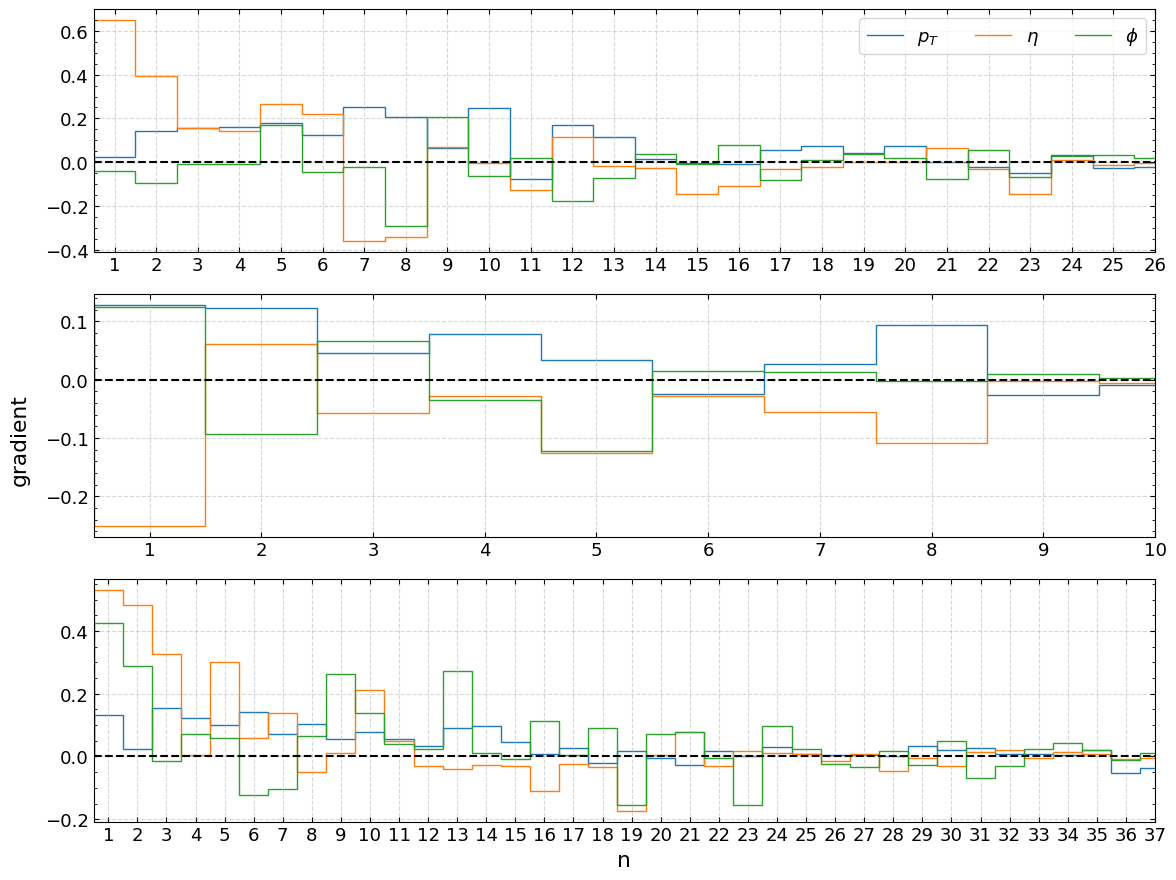

In [ ]:
from namespace import * 

@plot
def plot_jet_gradients(file, n=3, mag=False, switch=False):
    fig, axes = plt.subplots(n,1, figsize=(12,3*n))
    data = np.load(file)
    
    jets = data["jets"] # [jet, const, feature]
    paddings = data["paddings"]
    labels = data["labels"]
    gradients = data["gradients"]
    
    N = (~paddings).sum(1) 
    gradients[gradients==0] = np.nan 
    if switch: gradients *= -1
    if mag: gradients = np.abs(gradients)
    
    labels = [r"$p_T$", r"$\eta$", r"$\phi$"]
    
    for j in range(n):
        for f in range(3):
            axes[j].stairs(gradients[j,:,f], np.linspace(.5, 128.5, 129), 
                           label=labels[f] if j==0 else None, edgecolor=f"C{f}",
                           )
        axes[j].axhline(0, c="k", ls="--")
        axes[j].set_xticks(np.arange(1,129))
        axes[j].xaxis.set_tick_params(which='minor', length=0)
        plotter(grid=1, xlim=[0.5,np.max(N[j])], ax=axes[j])
        
    plotter(ax=axes[2], xlabel="n")
    fig.supylabel(r"gradient")
    axes[0].legend(ncols=3)
    

plot_jet_gradients(
    "/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/gradients_2000.npz", 
    savefig="gradients_TTBarBB_3.pdf",
    n=3,
    switch=True
    )

/home/home3/institut_thp/lcordes/gpu_env/miniconda/envs/main/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/home3/institut_thp/lcordes/gpu_env/miniconda/envs/main/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


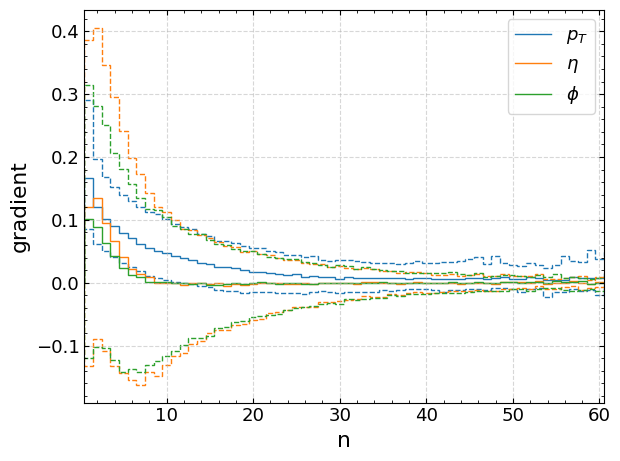

/home/home3/institut_thp/lcordes/gpu_env/miniconda/envs/main/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/home3/institut_thp/lcordes/gpu_env/miniconda/envs/main/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


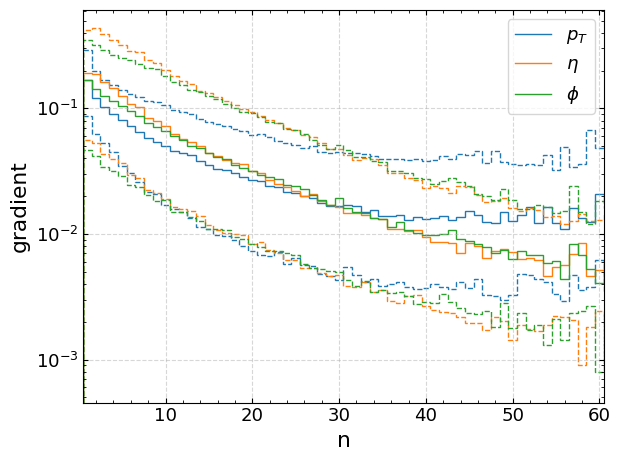

In [ ]:
from namespace import * 

@plot
def plot_jet_gradients_confidence_interval(file, j=None, mag=False, switch=False):
    data = np.load(file)
    
    jets = data["jets"] # [jet, const, feature]
    paddings = data["paddings"]
    labels = data["labels"]
    gradients = data["gradients"]
    
    N = (~paddings).sum(1) 
    gradients[gradients==0] = np.nan 
    if switch: gradients *= -1
    if mag: gradients = np.abs(gradients)
    
    median = np.nanmedian(gradients, axis=0)
    lower_bound = np.nanpercentile(gradients, 16, axis=0)
    upper_bound = np.nanpercentile(gradients, 84, axis=0)

    labels = [r"$p_T$", r"$\eta$", r"$\phi$"]
    
    for i in range(3):
        # plt.step(median[:,i], np.arange(129), label=labels[i], edgecolor=f"C{i}")
        # plt.step(lower_bound[:,i], np.arange(129), edgecolor=f"C{i}", ls="--")
        # plt.step(upper_bound[:,i], np.arange(129), edgecolor=f"C{i}", ls="--")
        plt.stairs(median[:,i], np.linspace(.5, 128.5, 129), label=labels[i], edgecolor=f"C{i}")
        plt.stairs(lower_bound[:,i], np.linspace(.5, 128.5, 129), edgecolor=f"C{i}", ls="--")
        plt.stairs(upper_bound[:,i], np.linspace(.5, 128.5, 129), edgecolor=f"C{i}", ls="--")
    
    plotter(grid=1, legend=True, xlim=[0.5, 60+0.5],
            ylabel=r"gradient", xlabel="n")
    

plot_jet_gradients_confidence_interval(
    "/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/gradients_2000.npz", 
    savefig="gradients_TTBarBB_median.pdf", 
    switch=True
    )

plot_jet_gradients_confidence_interval(
    "/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/gradients_2000.npz", 
    savefig="gradients_TTBarBB_median_mag.pdf",
    mag=True, 
    switch=True,
    yscale="log",
    )

$p_T = \exp(a\hat p_T + b) = b \exp(\hat p_T)^a$

In [49]:
fn = "/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/gradients_2000.npz"
fn2 = "/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/rollouts_0.8_1000.npz"

grads = np.load(fn)
rollouts = np.load(fn2)
table([grads["jets"][0], rollouts["jets"][0,0]])

╭────────────┬────────────╮
│ [26 17 13] │ [26 15 16] │
│ [24 16 16] │ [23 15 12] │
│ [23 15 15] │ [22 13 16] │
│ [23 15 16] │ [22 15 15] │
│ [22 16 17] │ [22 14 16] │
│ [22 16 15] │ [21 13 16] │
│ [22 14 15] │ [21 13 17] │
│ [20 14 13] │ [20 14 15] │
│ [17 14 20] │ [18 22 15] │
│ [17 16 10] │ [18 22 5]  │
│ [17 15 15] │ [18 16 18] │
│ [17 13 16] │ [17 14 16] │
│ [16 12 12] │ [16 15 16] │
│ [14 18 23] │ [16 13 15] │
│ [14 15 15] │ [14 13 21] │
│ [13 14 14] │ [14 13 16] │
│ [12 15 11] │ [14 14 20] │
│ [12 13 10] │ [13 15 9]  │
│ [11 21 18] │ [13 21 5]  │
│ [11 7 10]  │ [13 14 18] │
│ [10 12 14] │ [13 17 23] │
│ [9 13 10]  │ [13 11 16] │
│ [9 16 16]  │ [13 22 8]  │
│ [8 7 17]   │ [12 16 19] │
│ [8 16 18]  │ [12 18 12] │
│ [4 16 26]  │ [10 15 11] │
│ [0 0 0]    │ [8 14 16]  │
│ [0 0 0]    │ [7 16 8]   │
│ [0 0 0]    │ [0 7 5]    │
│ [0 0 0]    │ [0 0 0]    │
│ [0 0 0]    │ [0 0 0]    │
│ [0 0 0]    │ [0 0 0]    │
│ [0 0 0]    │ [0 0 0]    │
│ [0 0 0]    │ [0 0 0]    │
│ [0 0 0]    │ [0 0 

/.automount/home/home__home3/institut_thp/lcordes/HEP-FoundationModel-Aachen/praktikum.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/.automount/home/home__home3/institut_thp/lcordes/HEP-FoundationModel-Aachen/praktikum.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


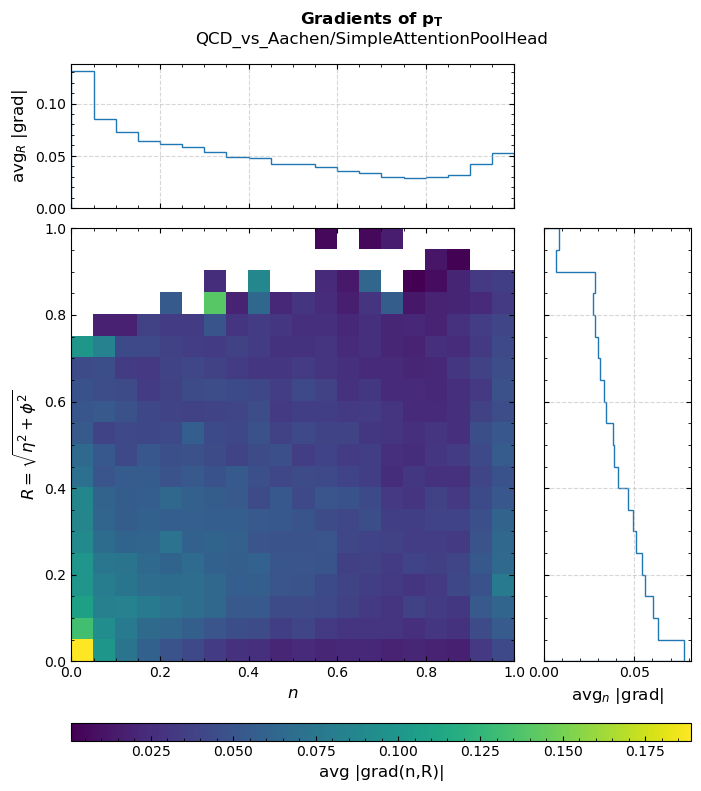

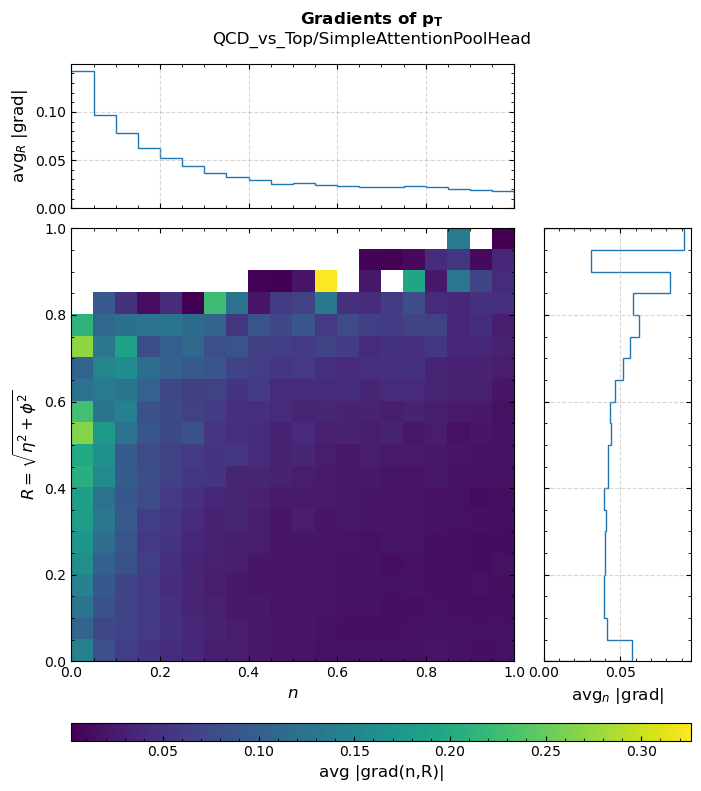

In [ ]:
from namespace import *

# @plot
def plot_jet_gradients(file, bins=50, normalize=True, j=0, sig=None):
    data = np.load(file)
    jet_tokens, paddings, labels, gradients = data["jets"], data["paddings"], data["labels"], data["gradients"]
    if sig is not None: 
        mask = labels==sig
        jet_tokens = jet_tokens[mask]
        paddings = paddings[mask]
        labels = labels[mask]
        gradients = gradients[mask]

    N = (~paddings).sum(1)

    # grad_magnitude = np.sqrt((gradients**2).sum(-1))
    
    grad_magnitude = np.sqrt((gradients**2).sum(-1)) if j is None else np.sqrt((gradients[...,j]**2))
    

    if "Aachen" in str(file):
        bin_names = ["pt_bins", "eta_bins", "phi_bins"]
        bins_vals = [pd.read_hdf(torch.load(Path(file).parents[2]/"model_best.pt", "cpu").bg_file, key=key) for key in bin_names]
    elif "Top" in str(file):
        bins_vals = [np.load(f"/net/data_ttk/hreyes/OneBin/preprocessing_bins/{x}_bins_1Mfromeach_403030.npy") for x in ["pt", "eta", "phi"]]
    
    jets = np.zeros_like(jet_tokens, dtype=float)
    for i in range(3):
        jets[..., i] = bins2values(jet_tokens[..., i], bins_vals[i])
    
    R = np.sqrt(jets[..., 1]**2 + jets[..., 2]**2)  # (N, C)

    grad = grad_magnitude.ravel()
    R = R.ravel()
    if normalize: 
        n = np.ravel([np.arange(jets.shape[1]) / n for n in N])
    else: 
        n = np.tile(np.arange(jets.shape[1]), jets.shape[0])

    mask = ~paddings.ravel() & np.isfinite(R)
    grad = grad[mask]
    R = R[mask]
    n = n[mask]

    H_sum, xedges, yedges = np.histogram2d(n, R, weights=grad, bins=[np.linspace(0,1,bins+1)]*2 if normalize else bins)
    H_count, _, _ = np.histogram2d(n, R, bins=[xedges, yedges])

    H_avg = np.full_like(H_sum, np.nan)
    np.divide(H_sum, H_count, where=H_count!=0, out=H_avg)

    fig, axes = plt.subplot_mosaic("A.\nCB\nDD", figsize=(8, 8 * 33/32),
                                   gridspec_kw={"width_ratios": [3,1], 
                                                "height_ratios": [4,12,1/2],
                                                "wspace": 0.1,
                                                "hspace": 0.1},
                                   )

    cbar = axes["C"].imshow(H_avg.T, aspect='auto', origin='lower',
               extent=[0, xedges[-1], 0, yedges[-1]],
               cmap='viridis')
    
    axes["A"].stairs(np.divide(H_sum.sum(1), H_count.sum(1)), xedges,)
    axes["B"].stairs(np.divide(H_sum.sum(0), H_count.sum(0)), yedges, orientation="horizontal")
    
    axes["A"].set_xticklabels([])
    axes["B"].set_yticklabels([])
    
    fig.colorbar(cbar, label="avg |grad(n,R)|", cax=axes["D"], orientation="horizontal")
    pos = axes["D"].get_position()
    axes["D"].set_position([pos.x0, pos.y0 - 0.05, pos.width, pos.height])
    
    plotter(ax=axes["C"], xlabel="$n$", ylabel=r"$R = \sqrt{\eta^2 + \phi^2}$")
    plotter(ax=axes["A"], xlim=xedges[[0,-1]], grid=1, ylabel="avg${_R}$ |grad|")
    plotter(ax=axes["B"], ylim=yedges[[0,-1]], grid=1, xlabel="avg${_n}$ |grad|")
    
    which = {0: "p_T",
            1: r"\eta",
            2: r"\phi",
            None: r"p_T, \eta, \phi\ (squared\ sum)"}
    
    sig_or_bg = {1: r"\ (signal)",
                 0: r"\ (background)",
                 None: ""}
    
    fig.text(0.5, 0.9, f"$\\mathbf{{Gradients\\ of\\ {which[j]}{sig_or_bg[sig]}}}$\n{'/'.join(file.split('/')[-5:-3])}", va="bottom", ha="center", fontsize=12,)

plot_jet_gradients("/net/data_ttk/lcordes/classifier_var_heads/QCD_vs_Aachen/SimpleAttentionPoolHead/tests/38870_10/gradients_2000.npz", bins=20, j=0, normalize=True, sig=None)

# plot_jet_gradients("/net/data_ttk/lcordes/classifier_var_heads/QCD_vs_Aachen/SimpleAttentionPoolHead/tests/38870_10/gradients_2000.npz", bins=20, j=None, 
#                    normalize=True, sig=0)

plot_jet_gradients("/net/data_ttk/lcordes/classifier_var_heads/QCD_vs_Top/SimpleAttentionPoolHead/tests/160000_8/gradients_2000.npz", bins=20, j=0, normalize=True, sig=None)

## Double Descend

find effective model complexity (EMC) by binary search

$\mathrm{EMC}_{\mathcal D, \epsilon} = \max\{n: \mathbb E_{S\sim\mathcal D^n}[\mathrm{Loss}_{S}(\mathcal T(S))] \le \epsilon\}$

EMC of the standard routine is $\sim 12500$ (w. dropout = 0.1) / $\sim 10000$ (without dropout)

/tmp/ipykernel_3426181/44162668.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap("magma")


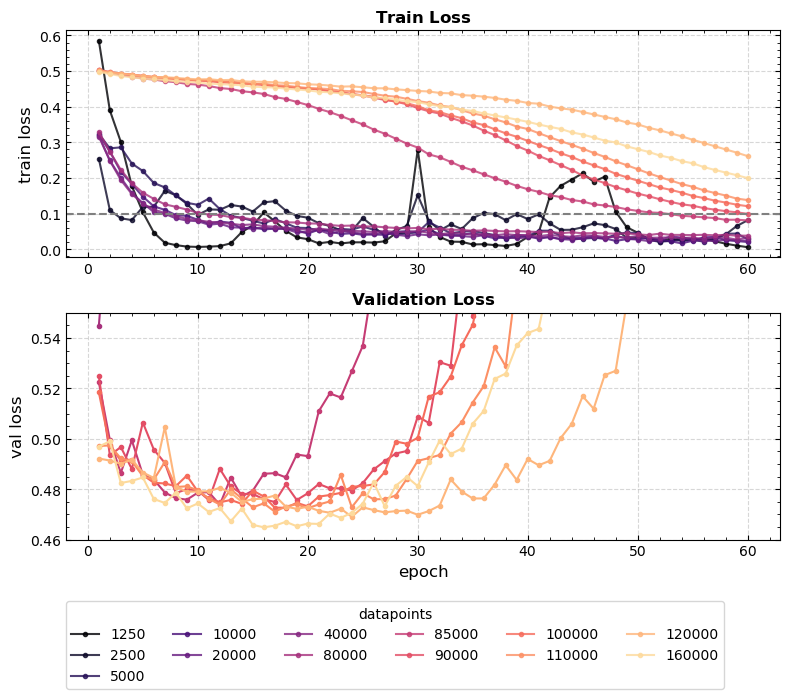

In [ ]:
from namespace import *
import matplotlib

def plot_loss(dir="test"):
    num_events = []
    train_loss = []
    val_loss = []
    for path in walk_dir("model_last", f"/net/data_ttk/lcordes/double_descend/{dir}"):
        model = torch.load(path, "cpu")
        num_events.append(int(path.parent.name))
        train_loss.append(model.train_loss)
        val_loss.append(model.val_loss)
        
    idx = np.argsort(num_events)
    num_events = [num_events[i] for i in idx]
    train_loss = [train_loss[i] for i in idx]
    val_loss = [val_loss[i] for i in idx]

    cmap = matplotlib.cm.get_cmap("magma")
    fig, axes = plt.subplots(2, 1, figsize=(8,6))
    for i, (train_loss, val_loss, n) in enumerate(zip(train_loss, val_loss, num_events)):
        axes[0].plot(reduce(train_loss, len(val_loss)), alpha=0.8, label=n, marker=".", c=cmap(i/len(num_events)))
        axes[1].plot(val_loss, marker=".", c=cmap(i/len(num_events)))
        
    axes[0].axhline(0.1, c="gray", ls="--") # label=r"$\epsilon=0.1$"
    plotter(ax=axes[0], ylabel="train loss", grid=1, bftitle="Train Loss")
        
    plotter(ax=axes[1], xlabel="epoch", ylabel="val loss", grid=1, bftitle="Validation Loss", ylim=[0.46,0.55]) # zooom:[0.46,0.55] # normal [0.46, 3]
    
    fig.legend(ncols=6, loc="upper center", bbox_to_anchor=(.5, 0), title="datapoints")
    # fig.legend(ncols=6, loc="lower center", bbox_to_anchor=(.5, 1))
    fig.tight_layout()
    
    
plot_loss(dir="train_models_no_backbone")

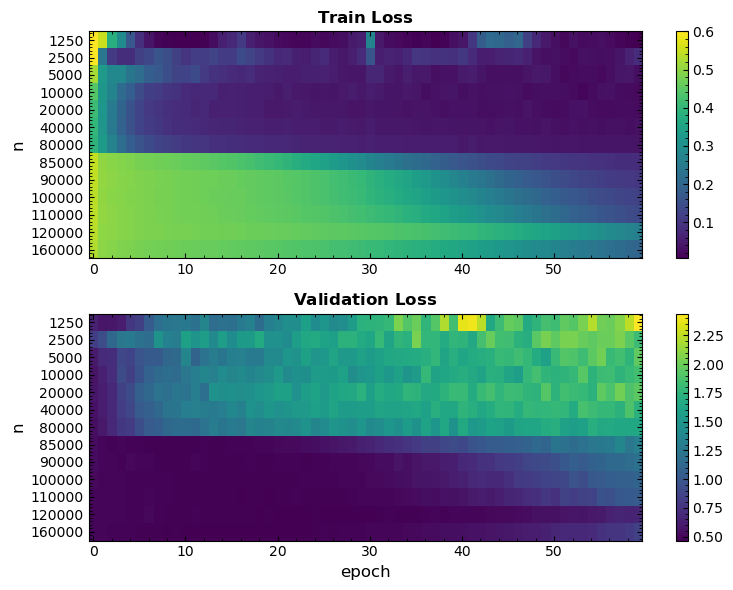

In [ ]:
from namespace import *

def plot_loss_2d(dir="test"):
    labels, train_loss, val_loss = [], [], []
    for path in walk_dir("model_last",f"/net/data_ttk/lcordes/double_descend/{dir}"):
        model = torch.load(path, "cpu")
        labels.append(path.parent.name)
        train_loss.append(model.train_loss[1:])
        val_loss.append(model.val_loss[1:])

    num_events = [int(label) for label in labels]

    xbins = min(min([len(x) for x in train_loss]), len(val_loss[0]))
    train_loss = [reduce(x, xbins) for x in train_loss]

    idx = np.argsort(num_events)
    num_events = [num_events[i] for i in idx]
    train_loss = [reduce(train_loss[i], len(val_loss[i])) for i in idx]
    val_loss = [val_loss[i] for i in idx]

    fig, [ax1, ax2] = plt.subplots(2,1, figsize=(8,6))

    img1 = ax1.imshow(np.clip(train_loss, 0, .6), aspect="auto")
    ax1.set_yticks(ticks=np.arange(len(num_events)), labels=num_events)
    plt.colorbar(img1, ax=ax1)
    plotter(ax=ax1, bftitle="Train Loss", ylabel="n")
    
    
    img2 = ax2.imshow(val_loss, aspect="auto")
    ax2.set_yticks(ticks=np.arange(len(num_events)), labels=num_events)
    plt.colorbar(img2, ax=ax2)
    plotter(ax=ax2, bftitle="Validation Loss", xlabel="epoch", ylabel="n")

# plot_loss_2d("test")
# plot_loss_2d("binary_search_1")
# plot_loss_2d("binary_search_2")
plot_loss_2d("train_models_no_backbone")

## Attention Rollout

### Plot Attn Distribution to compare to ParT

In [ ]:
from namespace import *

rollouts = list(walk_dir(
    pattern="rollouts",
    dir="/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3"))

attn, jets, paddings, labels = get_attn(
    "/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/model_best.pt", 20
)

attn = [np.asarray(x) for x in attn]
jets = np.asarray(jets)
paddings = np.asarray(paddings)
labels = np.asarray(labels)

  0%|          | 0/40 [00:00<?, ?it/s]

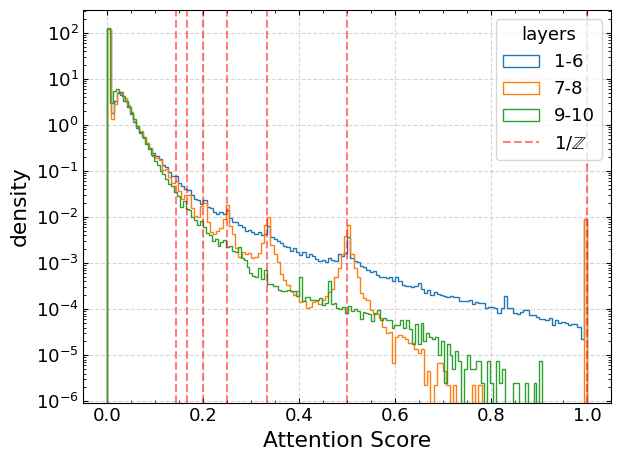

In [ ]:
from namespace import * 

@plot 
def plot_attn_dist(attn, bins=20):
    plt.hist(np.ravel(attn[0:6]), density=True, bins=bins, 
            histtype="step", label="1-6")
    plt.hist(np.ravel(attn[6:8]), density=True, bins=bins, 
            histtype="step", label="7-8")
    plt.hist(np.ravel(attn[8:]), density=True, bins=bins, 
            histtype="step", label="9-10")
    
    plt.axvline(1, c="r", alpha=0.5, ls="--", label="$1/\mathbb{Z}$")
    for i in range(2,8):
        plt.axvline(1/i, c="r", alpha=0.5, ls="--")

    plt.legend(title="layers")
    plotter(yscale="log", xlabel="Attention Score",
            ylabel="density", grid=1)
    
# plot_attn_dist(attn, bins=150, savefig="attn_weights_by_layer.pdf")

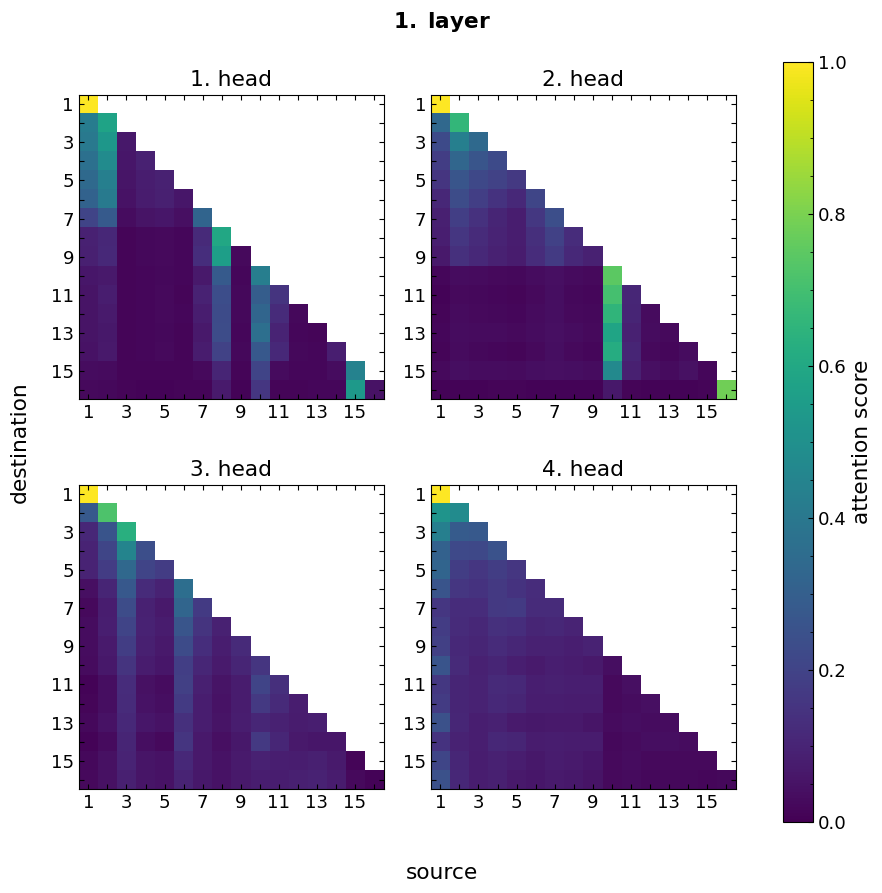

In [ ]:
from namespace import *
from matplotlib.ticker import MaxNLocator

@plot
def plot_attn_2d(attn, padding, causal_mask=False, cls_token=False, vmin=0, vmax=1):
    """ attn = [n_const, n_const]
        padding = [n_const]
    """
    n = np.sum(~padding)
    img = np.asarray(attn).copy()[:n + cls_token, :n + cls_token]
    
    if causal_mask: 
        img[~np.tri(n, dtype=bool)] = np.nan
    
    plt.imshow(img, extent=(not cls_token, n+1, not cls_token, n+1), vmin=vmin, vmax=vmax)
    
    ticks = np.arange(not cls_token, n + 1 + n%2)
    labels = np.array(ticks, dtype=object)
    labels[1::2] = ""
    if cls_token: labels[0] = "cls"
    plt.gca().set_xticks(ticks + 1/2, labels=labels)
    plt.gca().set_yticks(ticks + 1/2, labels=labels[::-1])
    plt.gca().tick_params(which='minor', bottom=False, top=False, left=False, right=False)

@plot 
def plot_attn_layer(attn, jet, layer):
    fig, axes = plt.subplot_mosaic("01C\n23C", height_ratios=[1,1], width_ratios=(10,10,1), figsize=(9,9))
    fig.supxlabel("source")
    fig.supylabel("destination")
    plotter(bfsuptitle=f"{layer+1}. layer")
        
    for head in range(4):
        plot_attn_2d(attn[layer][jet][head], paddings[jet], 
                    title=f"{head + 1}. head", ax=axes[f"{head}"],
                    causal_mask=True if layer<8 else False,
                    cls_token=False if layer<8 else True,
                    vmin=0,
                    vmax=np.nanmax(np.ravel(attn[layer][jet])))
        
    plt.colorbar(label="attention score", cax=axes["C"])
    plt.tight_layout()

jet = 5
for layer in range(len(attn)):
    plot_attn_layer(attn, jet, layer,
                    ) # savefig=f"attn_jet{jet + 1}_layer{layer+1}.pdf" 

### Plot Attn Rollout

[PosixPath('/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/rollouts_0.2_1000.npz'),
 PosixPath('/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/rollouts_0.4_1000.npz'),
 PosixPath('/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/rollouts_0.6_1000.npz'),
 PosixPath('/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/rollouts_0.8_1000.npz'),
 PosixPath('/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/rollouts_1_1000.npz'),
 PosixPath('/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/rollouts_0.0_1000.npz'),
 PosixPath('/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/rollouts_1.0_1000.npz')]


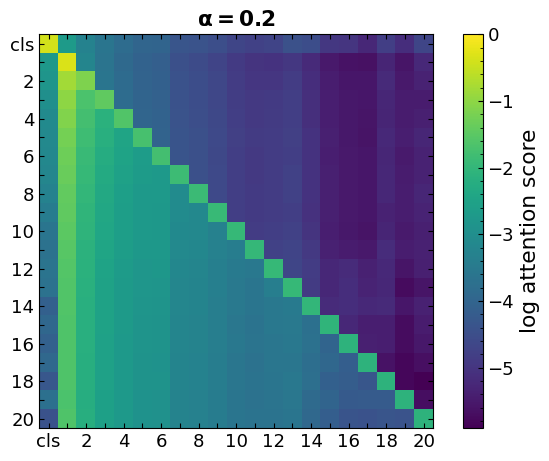

In [ ]:
from namespace import * 
from matplotlib.ticker import MaxNLocator
    
@plot
def plot_rollout2d(rollouts, jets, paddings, labels, causal_mask=False, j=0, log=False):
    n_const = (~np.array(paddings)).sum(-1).reshape(-1)
    
    if j is not None:
        rollout = rollouts[j]
        n = n_const[j]
    else: 
        rollouts[rollouts==0] = np.nan
        rollout = np.nanmean(rollouts, axis=0)
        rollout[~np.isfinite(rollout)] = np.nan
        n = np.max(n_const)
    
    img = rollout[:n,:n]
    if log: np.log(img, out=img)
    if causal_mask: img[~np.tri(n, dtype=bool)] = -np.inf

    plt.imshow(img, vmax=0 if log else 1)
    plt.colorbar(label=("log " if log else "") + "attention score")
    
    ticks = np.arange(0, n)
    labels = np.array(ticks, dtype=object)
    labels[1::2] = ""
    labels[0] = "cls"
    plt.gca().set_xticks(ticks, labels=labels)
    plt.gca().set_yticks(ticks, labels=labels)
    plt.gca().tick_params(which='minor', bottom=False, top=False, left=False, right=False)

    
rollouts = list(walk_dir(
    pattern="rollouts",
    dir="/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3"))
pprint(rollouts)

for rollout in [rollouts[0]]: 
    data = np.load(rollout)
    # plot_rollout_hist(data["rollouts"], data["jets"], 
    #                   data["paddings"], data["labels"], 
    #                   savefig=f"{rollout.stem}_hist.pdf")
    
    plot_rollout2d(data["rollouts"], data["jets"],
                   data["paddings"], data["labels"],
                   j=0, 
                   log=True,
                   savefig=f"{rollout.stem}_2d.pdf",
                   bftitle=r"\alpha="+re.findall(r"rollouts_(\d\.?\d?)", str(rollout))[0])

/home/home3/institut_thp/lcordes/gpu_env/miniconda/envs/main/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/home3/institut_thp/lcordes/gpu_env/miniconda/envs/main/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


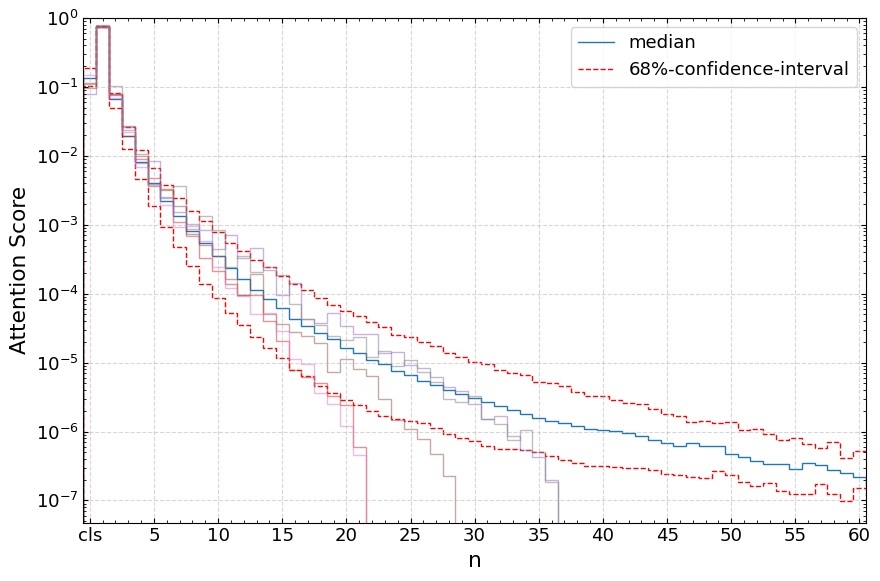

In [ ]:
from namespace import * 
@plot
def plot_mean_attn_rollout(rollouts, jets, paddings, labels, n_lim=128, xmax=50, n_jets=5, signal=None):
    n_const = (~paddings).sum(-1)
    
    cls_attn = rollouts[:, 0, :] # [jets, 129]
    if signal is True:
        cls_attn = cls_attn[labels==1]
        n_const = n_const[labels==1]
    elif signal is False:
        cls_attn = cls_attn[labels==0]
        n_const = n_const[labels==1]

    cls_attn = cls_attn[n_const<n_lim].reshape(-1, 129)
    cls_attn[cls_attn==0] = np.nan

    median = np.nanmedian(cls_attn, axis=0)
    lower = np.nanpercentile(cls_attn, 16, axis=0, )
    upper = np.nanpercentile(cls_attn, 84, axis=0, )
    
    bin_edges = np.arange(-0.5, 129.5)
    plt.stairs(median, bin_edges, label="median", edgecolor="C0")
    plt.stairs(upper, bin_edges, edgecolor="r", ls="--", label="68%-confidence-interval")
    plt.stairs(lower, bin_edges, edgecolor="r", ls="--")
    
    for i in range(n_jets):
        mask = np.isfinite(cls_attn[i])
        y = cls_attn[i][mask]
        plt.stairs(y, bin_edges[:np.sum(mask)+1], alpha=0.5)

    ticks = np.arange(0, 129, 5)
    labels = np.asarray(ticks, dtype=object)
    
    labels[0] = "cls"
    plt.xticks(ticks, labels=labels)
    plt.yticks(ticks, labels=labels)
    # plt.tick_params(which='minor', bottom=False, top=False, left=False, right=False)
    
    plotter(xlim=(-0.5, xmax+.5), 
            ylim=(0.8*np.nanmin(lower), 1), 
            yscale="log", 
            grid=True, 
            xlabel="n", 
            ylabel="Attention Score", 
            legend=True)


data = np.load(r"/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/rollouts_0.8_1000.npz")

plot_mean_attn_rollout(data["rollouts"], data["jets"], 
                       data["paddings"], data["labels"], 
                       figsize=(9,6), xmax=60, signal=None) # savefig="cls_attn_conf_int.pdf"

/tmp/ipykernel_3661776/3648715484.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=2, title=f"Corr = {np.corrcoef(log_pt, log_cls_attn)[0][1]:.3}\nfit: ${fit[0]:.3}\\cdot \ln p_T {fit[1]:.3}$")
/tmp/ipykernel_3661776/3648715484.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=2, title=f"Corr = {np.corrcoef(log_pt, log_cls_attn)[0][1]:.3}\nfit: ${fit[0]:.3}\\cdot \ln p_T {fit[1]:.3}$")


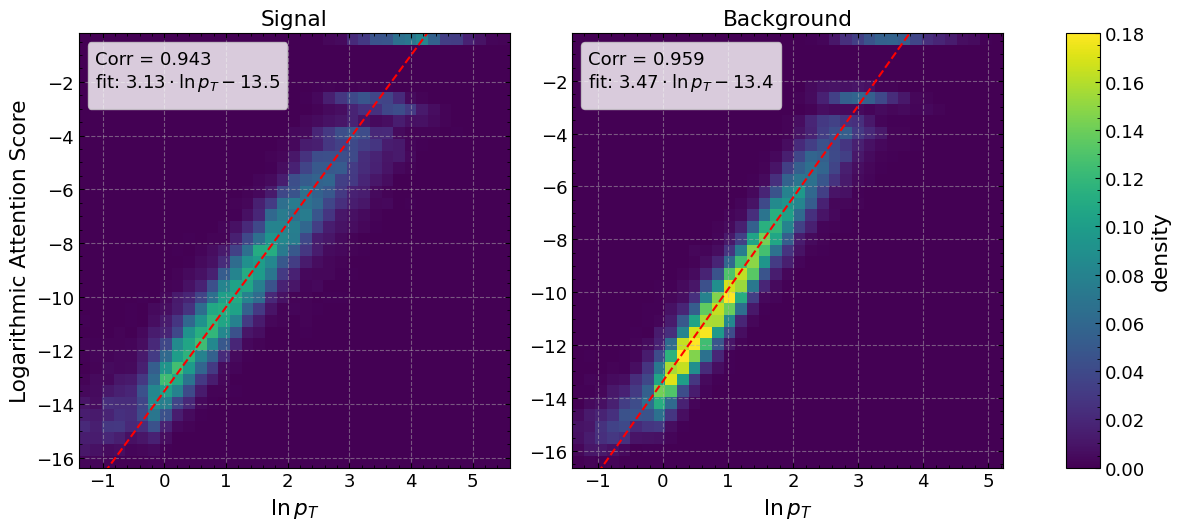

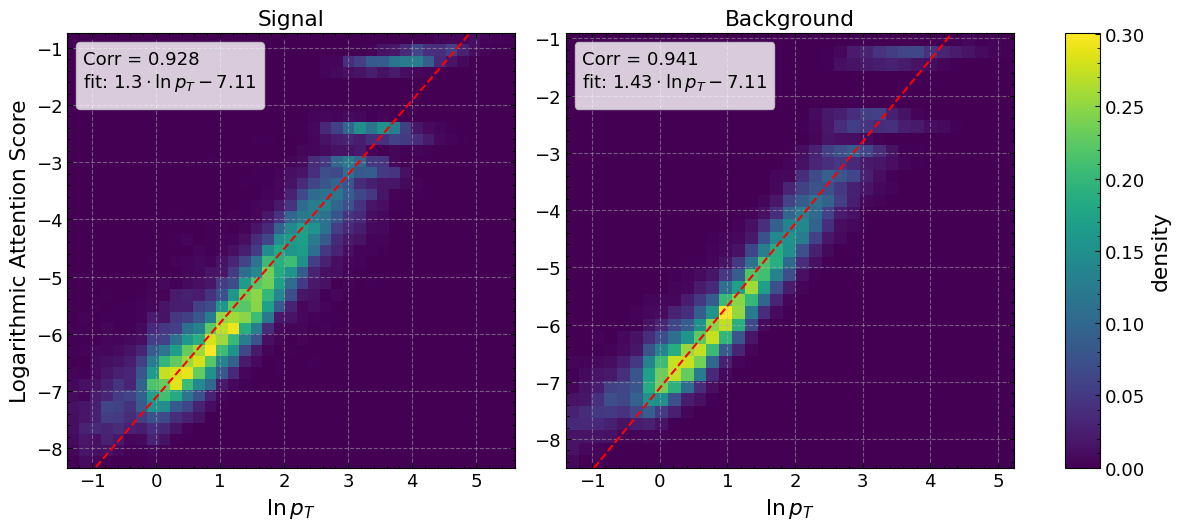

In [ ]:
from namespace import * 

@plot
def plot_mean_attn_rollout_pt(rollouts, jets, paddings, labels, xmax=50, n_jets=5, signal=None, bins=39, vmax=0.18, p0=[1,0]):
    n_const = (~paddings).sum(-1)
    
    pt = bins2values(jets[:,:,0], np.load("/net/data_ttk/lcordes/Semi-Visible/aachen/preprocessing_bins/pt_bins_aachen_disc.npy"))
    
    cls_attn = rollouts[:, 0, :] # [jets, 129]
    if signal is True:
        cls_attn = cls_attn[labels==1]
        n_const = n_const[labels==1]
        paddings = paddings[labels==1]
        pt = pt[labels==1]
        plt.title("Signal")
    elif signal is False:
        cls_attn = cls_attn[labels==0]
        n_const = n_const[labels==0]
        paddings = paddings[labels==0]
        pt = pt[labels==0]
        plt.title("Background")
        
    pt = np.array(pt[~paddings])
    nn = np.array(flat([np.linspace(0, 1, n) for n in n_const]))
    cls_attn = cls_attn[:,1:][~paddings]
    
    mask = np.isfinite(pt) & np.isfinite(nn) & np.isfinite(cls_attn)
    log_pt, nn, log_cls_attn = log(pt[mask]), nn[mask], log(cls_attn[mask])
    
    z, x_edges, y_edges, _ = plt.hist2d(log_pt, log_cls_attn, bins=(bins,bins), 
                                        density=True, vmax=vmax)
    # mask = (0 < log_pt) & (log_pt < 3)
    # fit = np.polyfit(log_pt[mask], log_cls_attn[mask], 1)
    fit = odr(log_pt, log_cls_attn, p0)
    plt.plot(x:=np.linspace(np.min(log_pt), np.max(log_pt), 100), 
             np.polyval(fit, x), ls="--", c="r")
    
    plotter(grid=True,
            xlabel=r"$\ln p_T$")
    
    plt.legend(loc=2, title=f"Corr = {np.corrcoef(log_pt, log_cls_attn)[0][1]:.3}\nfit: ${fit[0]:.3}\\cdot \ln p_T {fit[1]:.3}$")

data = np.load(r"/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/rollouts_0.8_1000.npz")

fig, axes = plt.subplots(1, 3, figsize=(12,5.5), width_ratios=(10,10,.8),)


plot_mean_attn_rollout_pt(data["rollouts"], data["jets"], 
                       data["paddings"], data["labels"], 
                       xmax=60, signal=True, bins=37,
                       ax=axes[0],
                       p0=[2.95, -13.3]) # savefig="cls_attn_conf_int.pdf"


plot_mean_attn_rollout_pt(data["rollouts"], data["jets"], 
                       data["paddings"], data
                       ["labels"], 
                       xmax=60, signal=False, bins=37,
                       ax=axes[1], 
                       p0=[3.41, -13.4])

plotter(ax=axes[0], ylabel="Logarithmic Attention Score")
plt.colorbar(cax=axes[2], label="density")
plt.tight_layout()
fig.savefig(plots_path + "ln_pt_vs_ln_cls_attn.pdf")


data = np.load(r"/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/rollouts_0.4_1000.npz")

fig, axes = plt.subplots(1, 3, figsize=(12,5.5), width_ratios=(10,10,.8),)


plot_mean_attn_rollout_pt(data["rollouts"], data["jets"], 
                       data["paddings"], data["labels"], 
                       xmax=60, signal=True, bins=39,
                       ax=axes[0], vmax=None, p0=[1.2, -7]) # savefig="cls_attn_conf_int.pdf"


plot_mean_attn_rollout_pt(data["rollouts"], data["jets"], 
                       data["paddings"], data
                       ["labels"], 
                       xmax=60, signal=False, bins=35,
                       ax=axes[1], vmax=None, p0=[1.42, -7.19])

plotter(ax=axes[0], ylabel="Logarithmic Attention Score")
plt.colorbar(cax=axes[2], label="density")
plt.tight_layout()
fig.savefig(plots_path + "ln_pt_vs_ln_cls_attn_0.4.pdf")

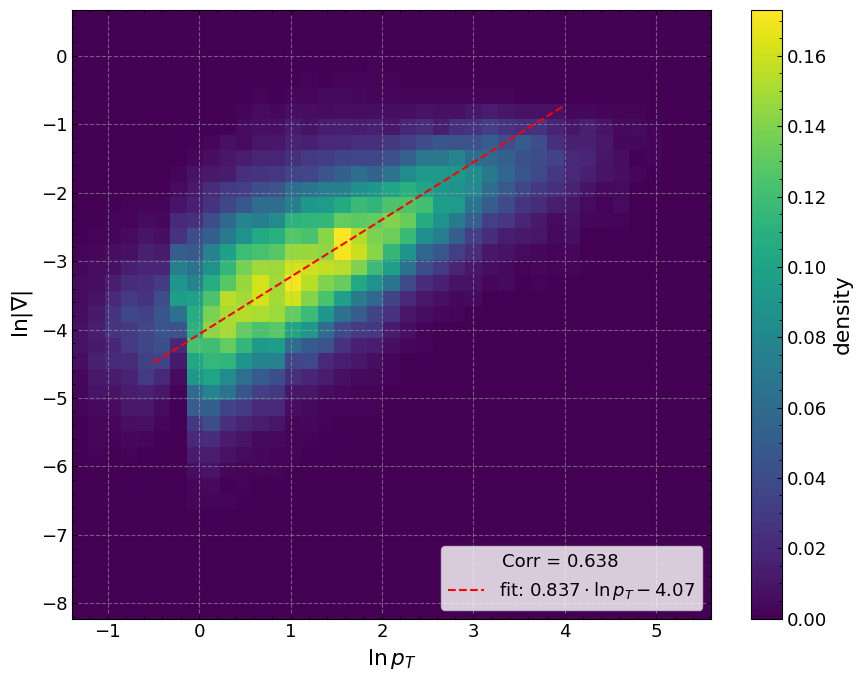

In [ ]:
#  gradients 
from namespace import * 

@plot
def plot_jet_gradients_by_pt(file, switch=False, sig=None, bins=39):
    data = np.load(file)
    
    jets = data["jets"] # [jet, const, feature]
    paddings = data["paddings"]
    labels = data["labels"]
    gradients = data["gradients"]
    
    if sig is not None:
        jets = jets[labels==sig]
        paddings = paddings[labels==sig]
        gradients = gradients[labels==sig]
    
    pt = bins2values(jets[:,:,0], np.load("/net/data_ttk/lcordes/Semi-Visible/aachen/preprocessing_bins/pt_bins_aachen_disc.npy"))
    N = (~paddings).sum(1) 
    
    gradients = np.abs(gradients).mean(-1)
    
    mask = (~paddings) & np.isfinite(pt) & np.isfinite(gradients)
    ln_pt, ln_gradients = log(pt[mask]), log(gradients[mask])
    
    plt.hist2d(ln_pt, ln_gradients, [bins]*2, density=True)
    
    fit = odr(ln_pt, ln_gradients, [0.837, -4.07])
    plt.plot(x:=np.linspace(-.5,4,10), np.polyval(fit, x), ls="--", c="r", 
             label=f"fit: ${fit[0]:.3}\cdot\ln p_T {fit[1]:.3}$")
        
    plotter(grid=1, ylabel=r"$\ln |\nabla |$", xlabel=r"$\ln p_T$")
    plt.colorbar(label="density")
    plt.legend(title=f"Corr = {np.corrcoef(ln_pt, ln_gradients)[0,1]:.3}    ", loc=4)
    
plot_jet_gradients_by_pt(
    "/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/gradients_2000.npz",  
    sig=None, bins=39, figsize=(9,7),
    savefig=f"ln_pt_vs_ln_grad_2d.pdf"
    )

/tmp/ipykernel_101194/4092963835.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  histtype="step", edgecolor=cm.get_cmap("viridis")(prev / np.max(prevs))


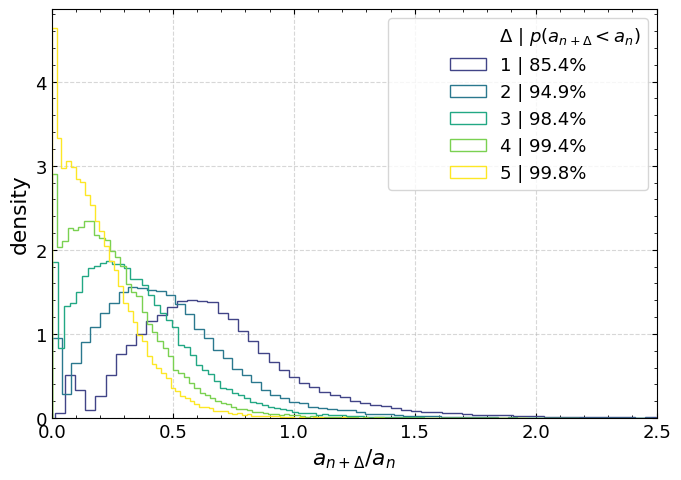

In [ ]:
import scipy.optimize
import scipy.special
from namespace import * 
import sympy as sp 

@plot
def plot_smaller_then_prev(rollouts, jets, paddings, labels, n_lim=128, xmax=50, n_jets=25, prevs=[1,2,3,4,5]):
    n_const = (~paddings).sum(-1)
    pt = bins2values(jets[:,:,0], np.load("/net/data_ttk/lcordes/Semi-Visible/aachen/preprocessing_bins/pt_bins_aachen_disc.npy"))
    
    cls_attn = rollouts[:, 0, :] # [jets, 129]
    cls_attn[cls_attn==0] = np.nan

    fracs = cls_attn[:, 2:] / cls_attn[:, 1:-1]
    smaller_then_preceding = (fracs < 1)
    mask = ~paddings[:, 1:]
    percent_smaller_then_preceding = np.mean(smaller_then_preceding, where=mask)
    
    # fracs = cls_attn[:, 3:] / cls_attn[:, 1:-2]
    # smaller_then_ppreceding = (fracs < 1)
    # mask = ~paddings[:, 2:]
    # percent_smaller_then_ppreceding = np.mean(smaller_then_ppreceding, where=mask)
    for prev in prevs:
        fracs = (cls_attn[:, 1+prev:] / cls_attn[:, 1:-prev]).ravel()
        perc_smaller = np.mean(fracs[np.isfinite(fracs)] < 1)
                
        vals, bins, _ = plt.hist(
            fracs, bins=100, density=True, 
            label=f"{prev} | {perc_smaller:.1%}", 
            histtype="step", edgecolor=cm.get_cmap("viridis")(prev / np.max(prevs))
            )
        plotter(yscale="linear", grid=True, xlabel=r"$a_{n+\Delta}/a_n$", ylabel="density", xlim=(-0,2.5))
    
    plt.legend(title=r"                  $\Delta$ | $p(a_{n+\Delta}<a_n)$")
    
    
data = np.load(r"/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/rollouts_0.8_1000.npz")
plot_smaller_then_prev(data["rollouts"], data["jets"], data["paddings"], data["labels"],
                       savefig="smaller_then_prev.pdf", figsize=(7,5))

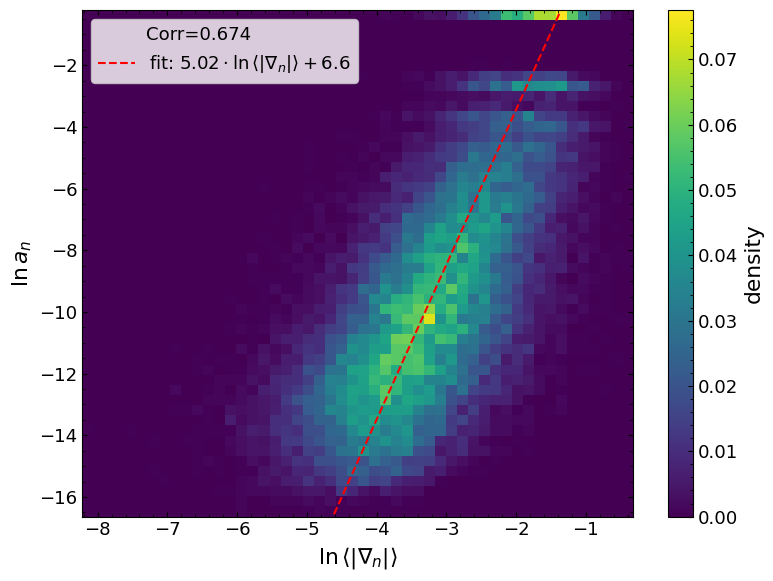

In [ ]:
from namespace import * 

@plot 
def plot_grad_roll_corr(grad_file, roll_file, pseudo_sort=False):
    grad_data = np.load(grad_file) 
    roll_data = np.load(roll_file) 
    
    paddings = grad_data["paddings"][:1000]
    n = (~paddings).sum(-1)
    grads = grad_data["gradients"][:1000]
    cls_attn = roll_data["rollouts"][:1000, 0, 1:]

    if pseudo_sort: 
        idx = np.argsort(n) 
        grads = grads[idx[:-1]]
        cls_attn = cls_attn[idx[1:]]
    
    tot_grads = np.abs(grads).mean(-1)
    cls_attn = cls_attn
    
    mask = (cls_attn!=0) & (tot_grads!=0)
    tot_grads, cls_attn = np.log(tot_grads[mask]), np.log(cls_attn[mask])
    
    hist = plt.hist2d(tot_grads, cls_attn, [50, 50], density=True)

    fit = [5.02, 6.6]
    fit = odr(tot_grads, cls_attn, fit)
    
    plt.plot(x:=np.linspace(-5,2,100), np.polyval(fit, x), ls="--", c="r", 
             label=fr"fit: ${fit[0]:.3}\cdot\ln\langle|\nabla_n|\rangle + {fit[1]:.3}$")
    
    plt.legend(loc=2, title=f"Corr={np.corrcoef(tot_grads,cls_attn)[1,0]:.3}         ")
    
    plt.colorbar(label="density")
    plotter(xlabel=r"$\ln\langle|\nabla_n|\rangle$", ylabel=r"$\ln a_n$"), # 0.561

plot_grad_roll_corr("/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/gradients_1000.npz",
                    "/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/rollouts_0.8_1000.npz", 
                    savefig="ln_a_vs_ln_grad_2d.pdf", 
                    figsize=(8,6))


p(a) = 0.0308
p(∇) = 0.0957
<Probability table of attention/gradient scores being greater then their predecessors. The results of the different approaches have a Pearson Correlation Coefficient of 0.188.>
╭─────┬───────────┬───────────╮
│     │   aᵢ>aᵢ₊₁ │   aᵢ<aᵢ₊₁ │
├─────┼───────────┼───────────┤
│ >₊₁ │     0.499 │     0.047 │
│ <₊₁ │     0.355 │     0.1   │
╰─────┴───────────┴───────────╯
table saved to '/home/home3/institut_thp/lcordes/Bachelor_Thesis/latex/tables/attn_vs_grad_corr.tex'
╭───────┬───────╮
│ 0.545 │ 0.455 │
╰───────┴───────╯
╭───────┬───────╮
│ 0.854 │ 0.146 │
╰───────┴───────╯
Corr = 0.188
Corr = -0.00278


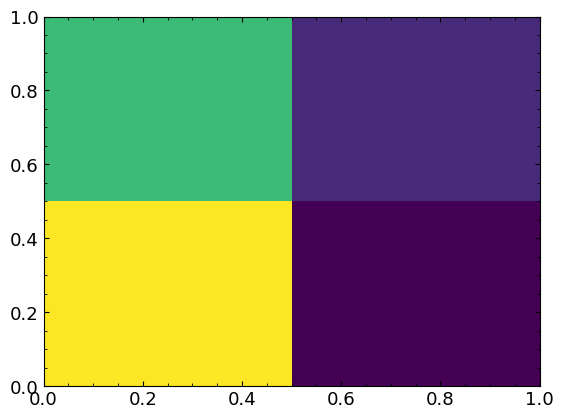

In [ ]:
from namespace import *
from praktikum import *

data = np.load("/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/rollouts_0.8_1000.npz")
jets = data["jets"]
paddings = data["paddings"]
cls_attn = data["rollouts"][:,0,:]

data = np.load("/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/gradients_1000.npz")
grads = data["gradients"]

grads = np.abs(grads).mean(-1)
# grads = np.sqrt((grads**2).sum(-1))

cls_btp = cls_attn[:,2:] > cls_attn[:,1:-1]
grad_btp = grads[:,1:] > grads[:,:-1]
mask = (~paddings)[:,1:] # corr = 0.188 (abs mean), 0.184 (sq sum), 0.181 (max)

# cls_btp = cls_attn[:,3:] > cls_attn[:,1:-2]
# grad_btp = grads[:,1:-1] > grads[:,:-2]
# mask = (~paddings)[:,:-2] # corr = 0.0522

x = cls_btp[:,:][mask]
y = grad_btp[:,:][mask]

vals, bins, _, _ = plt.hist2d(x, y, (2,2), density=True)


print(f"p(a) = {np.average(cls_btp):.3}")
print(f"p(∇) = {np.average(grad_btp):.3}")
table(vals / np.sum(vals),
      ["$a_{i}>a_{i+1}$", "$a_{i}<a_{i+1}$"],
      index_column=[r"$\nabla_{i}>\nabla_{i+1}$", r"$\nabla_{i}<\nabla_{i+1}$"],
      caption=f"Probability table of attention/gradient scores being greater then their predecessors. The results of the different approaches have a Pearson Correlation Coefficient of {np.corrcoef(x,y)[0,1]:.3}.",
      filename="attn_vs_grad_corr.tex")
table(np.sum(vals / np.sum(vals), axis=0))
table(np.sum(vals / np.sum(vals), axis=1))

print(f"Corr = {np.corrcoef(x,y)[0,1]:.3}")
np.random.shuffle(y)
print(f"Corr = {np.corrcoef(x,y)[0,1]:.3}")


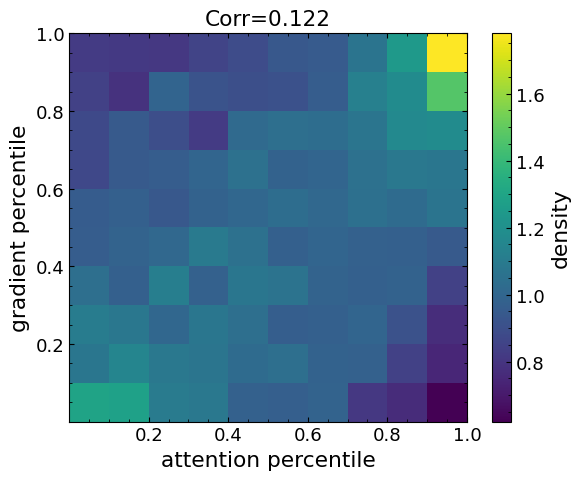

In [ ]:
from namespace import *
from praktikum import *

data = np.load("/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/rollouts_0.8_1000.npz")
jets = data["jets"]
pt = bins2values(jets[:,:,0], np.load("/net/data_ttk/lcordes/Semi-Visible/aachen/preprocessing_bins/pt_bins_aachen_disc.npy"))
paddings = data["paddings"]
cls_attn = data["rollouts"][:,0,1:]

grads = np.load("/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/CLSToken_ReducedLR_3/tests/34983_9/gradients_1000.npz")["gradients"]
grads = np.abs(grads).mean(-1)

def mask(x, y, ravel=True):
    mask = ~paddings & np.isfinite(x) & np.isfinite(y)
    return x[mask].ravel(), y[mask].ravel()

def get_percentiles(x, y, bins=(37, 1000)):
    A, x_edges, y_edges = np.histogram2d(*mask(x, y), bins=bins)
    shape = np.shape(x)
    x, y = np.asarray(x).ravel(), np.asarray(y).ravel()
    
    cdf = A.cumsum(1) / A.sum(1, keepdims=True)
    
    x_bin = np.digitize(x, x_edges)
    y_bin = np.digitize(y, y_edges)
    
    valid = (0<x_bin) & (0<y_bin) & (x_bin<len(x_edges)) & (y_bin<len(y_edges))

    x_bin[~valid] = 1
    y_bin[~valid] = 1
    
    percentiles = cdf[x_bin-1, y_bin-1]
    percentiles[~valid] = np.nan

    return percentiles.reshape(shape)

a_percentiles = get_percentiles(log(pt), log(cls_attn))
g_percentiles = get_percentiles(log(pt), log(grads))

@plot
def plot_a_g_percentiles(a_percentiles, g_percentiles):
    vals, _, _, _ = plt.hist2d(*mask(a_percentiles, g_percentiles), bins=[10]*2, density=True,)

    plt.colorbar(label="density")
    plotter(xlabel="attention percentile", ylabel=r"gradient percentile",
            title=f"Corr={np.corrcoef(*mask(a_percentiles, g_percentiles))[0,1]:.3}",)
    
plot_a_g_percentiles(a_percentiles, g_percentiles, 
                     figsize=(6,5),
                     savefig="attn_perc_vs_grads_perc.pdf") # savefig="attn_perc_vs_grads_perc.pdf"

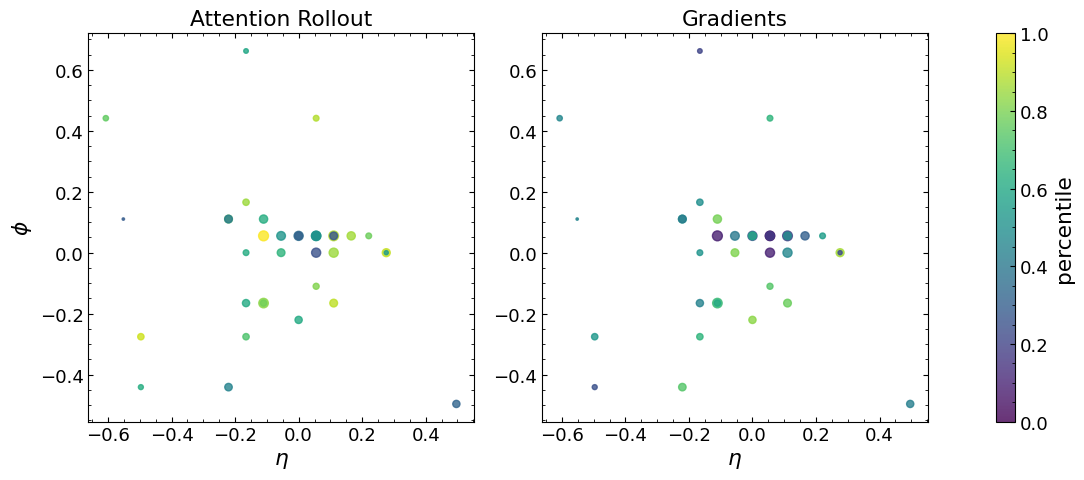

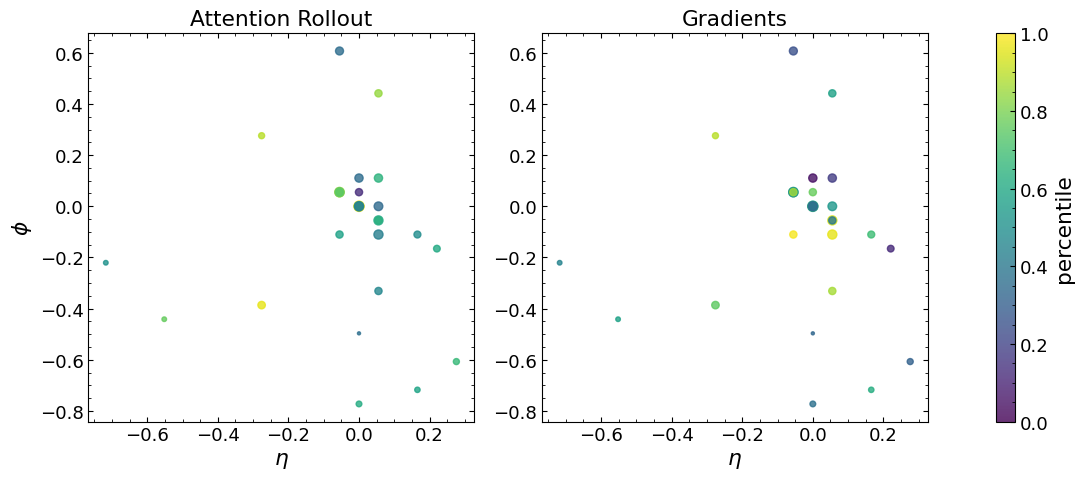

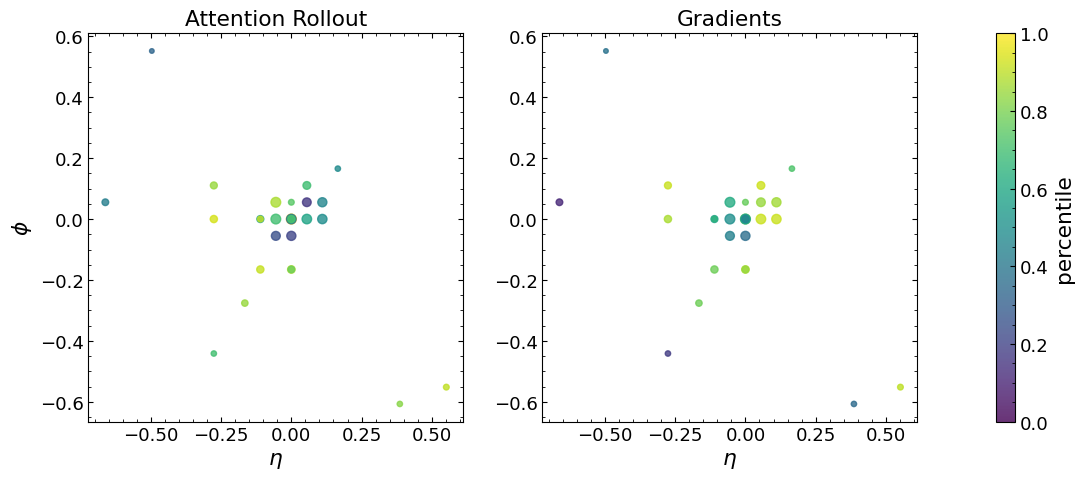

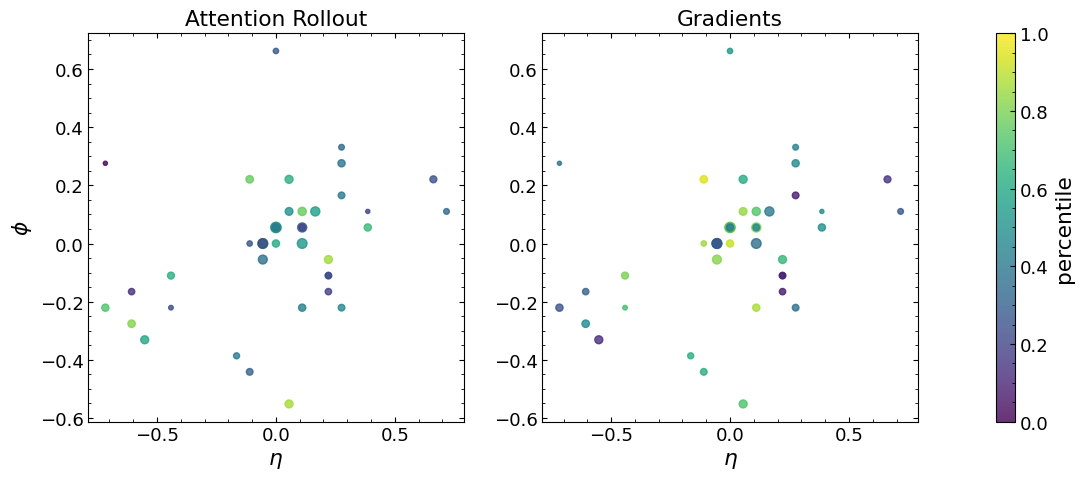

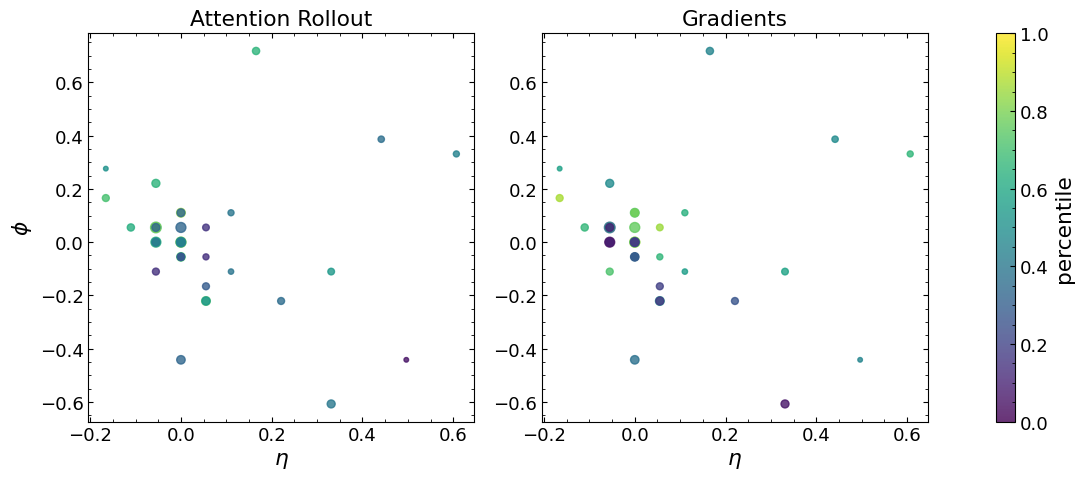

In [ ]:
def plot_jet_percentile(jet, a_percentiles, g_percentiles, fn=None):
    cmap = matplotlib.colormaps["viridis"]
    fig, ax = plt.subplots(1, 3, figsize=(10.5,5), width_ratios=[10, 10, 0.5]) 
    eta = bins2values(jet[:,1], np.load("/net/data_ttk/lcordes/Semi-Visible/aachen/preprocessing_bins/eta_bins_aachen_disc.npy"))
    phi = bins2values(jet[:,2], np.load("/net/data_ttk/lcordes/Semi-Visible/aachen/preprocessing_bins/phi_bins_aachen_disc.npy"))
    
    ax[0].scatter(eta, phi, 1 + 2*jet[:,0], c=cmap(a_percentiles), alpha=0.8)
    plotter(ax=ax[0], xlabel=r"$\eta$", ylabel=r"$\phi$",
            title="Attention Rollout")
    
    sc = ax[1].scatter(eta, phi, 1 + 2*jet[:,0], c=cmap(g_percentiles), alpha=0.8)
    plotter(ax=ax[1], xlabel=r"$\eta$", 
            title="Gradients")
    
    plt.colorbar(sc, cax=ax[2], label="percentile")
    if fn: 
        fig.savefig(plots_path + fn, bbox_inches="tight")

for i,j in enumerate([1,2,6,7,8]):
    plot_jet_percentile(jets[j], a_percentiles[j], g_percentiles[j],
                        fn=f"a_g_percentiles_{i}.pdf")

In [16]:
table([[x for x in jets[0]], cls_attn[0], grads[0] , paddings[0]])

╭────────────┬────────────┬───────────┬───────╮
│ [27 15 15] │ 0.769      │ 0.139     │ False │
│ [25 15 15] │ 0.077      │ 0.214     │ False │
│ [24 15 16] │ 0.020      │ 0.275     │ False │
│ [24 16 15] │ 0.009      │ 0.428     │ False │
│ [23 16 15] │ 0.005      │ 0.356     │ False │
│ [23 14 15] │ 0.003      │ 0.189     │ False │
│ [22 15 15] │ 0.001      │ 0.118     │ False │
│ [22 16 15] │ 0.001      │ 0.220     │ False │
│ [22 15 17] │ 0.000      │ 0.212     │ False │
│ [20 15 16] │ 0.000      │ 0.130     │ False │
│ [19 15 16] │ 0.000      │ 0.103     │ False │
│ [15 16 17] │ 9.568·10⁻⁵ │ 0.089     │ False │
│ [15 11 18] │ 9.646·10⁻⁵ │ 0.129     │ False │
│ [14 15 12] │ 3.994·10⁻⁵ │ 0.087     │ False │
│ [13 10  4] │ 2.075·10⁻⁵ │ 0.030     │ False │
│ [12 16 15] │ 7.887·10⁻⁶ │ 0.120     │ False │
│ [11  8  3] │ 6.284·10⁻⁶ │ 0.035     │ False │
│ [10 17 16] │ 5.128·10⁻⁶ │ 0.148     │ False │
│ [ 8 22  4] │ 3.222·10⁻⁶ │ 0.013     │ False │
│ [ 7 19 12] │ 2.445·10⁻⁶ │ 0.088     │ 

## Figures for the thesis

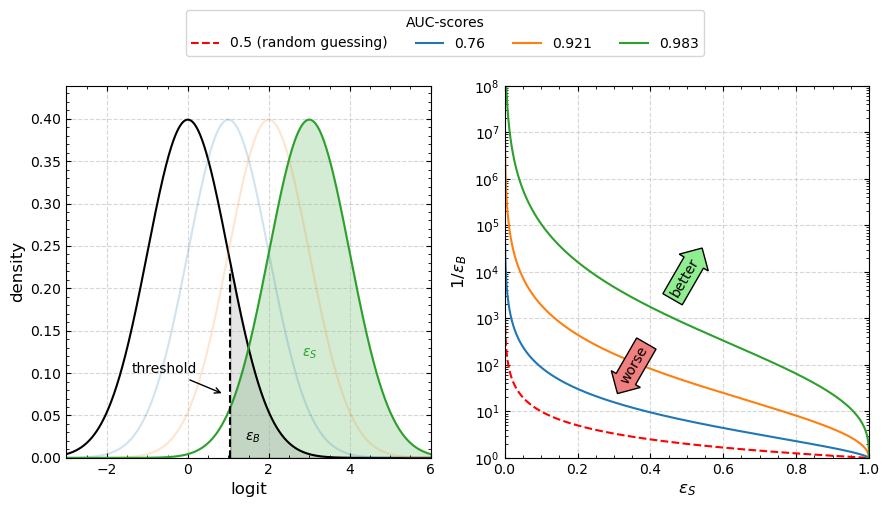

In [ ]:
# ROC example plot
from namespace import *
plots_path = "../latex/figures/"

def plot_roc_example(inv=-1):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9,4.5))
    
    e_S = np.linspace(0,1,10000)
    plt.plot(e_S, e_S**inv, ls="--", c="r", label=f"0.5 (random guessing)")
    
    seps = [1, 2, 3]
    x = np.linspace(-3, max(seps)+3, 10000)
    ax1.plot(x, stats.norm.pdf(x), c="k")
    for i in range(len(seps)):
        e_S = 1 - stats.norm.cdf(np.linspace(-10,10,10000), loc=seps[i])
        e_B = 1 - stats.norm.cdf(np.linspace(-10,10,10000))
        ax2.plot(e_S, e_B**inv, label=np.round(1 + (e_B[1:] * np.diff(e_S)).sum(), 3))
        if i+1 == len(seps):
            ax1.plot(x, stats.norm.pdf(x, loc=seps[i]), alpha=1)
            idx = 4500
            ax1.axvline(x[idx], 
                        0, stats.norm.pdf(x[idx])*2.2, 
                        ls="--", c="k")
            ax1.fill_between(x[idx:], 
                             np.zeros_like(e_S[idx:]),
                             stats.norm.pdf(x[idx:], loc=seps[i]), 
                             facecolor=f"C{i}", alpha=0.2, edgecolor=f"C{i}")
            
            ax1.fill_between(x[idx:], 
                             np.zeros_like(e_S[idx:]),
                             stats.norm.pdf(x[idx:]), 
                             facecolor=f"gray", alpha=0.2, edgecolor=f"k")
            ax1.text(3, 0.12, r"$\epsilon_S$", c=f"C{i}", ha="center")
        else:
            ax1.plot(x, stats.norm.pdf(x, loc=seps[i]), alpha=0.2)
        
    ax1.set_xlabel("logit")
    ax1.set_ylabel("density")
    ax1.set_xlim(min(x), max(x))
    ax1.set_ylim(0, stats.norm.pdf(0)*1.1)
    
    ax2.set_xlabel(r"$\varepsilon_S$")
    ax2.set_ylabel(r"$1/\varepsilon_B$")
    ax2.set_xlim(0,1)
    if inv==-1:
        ax2.set_yscale("log")
        ax2.set_ylim(1, 1e8)
    else: 
        ax2.set_ylim(0,1)
        
    ax1.grid(ls="--", alpha=0.5)
    ax2.grid(ls="--", alpha=0.5)
    fig.legend(ncols=4, loc="lower center", bbox_to_anchor=(0.5, 1), title="AUC-scores")
    
    plt.text(0.45, 3e3, "better", bbox=dict(boxstyle="rarrow", facecolor="lightgreen"), rotation=60)
    plt.text(0.31, 4e1, "worse", bbox=dict(boxstyle="larrow", facecolor="lightcoral"), rotation=60)
    
    ax1.text(1.4, 0.02, r"$\epsilon_B$")
    
    ax1.annotate("threshold", xy=[0.9, 0.075], xytext=[-1.4, 0.1], 
                 arrowprops=dict(arrowstyle="->"))
    # plt.annotate("threshold", xy=[0.05, 1], xytext=[0, 0.1],,)
    
    plt.tight_layout()
    plt.draw()
    # plt.savefig(plots_path + "roc_example.pdf", bbox_inches="tight")

plot_roc_example()

plot saved as /home/home3/institut_thp/lcordes/Bachelor_Thesis/code/plots/training_foundation_ttbar.pdf


'tmp = list(walk_dir("", "/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/MaxPool_Scratch/logs"))\nplot_training(\n    str(tmp[1]),\n    train_ylim=(0.5, 0.6),\n    # savefig="training_classifier_aachen_linear_baseline.pdf"\n    )'

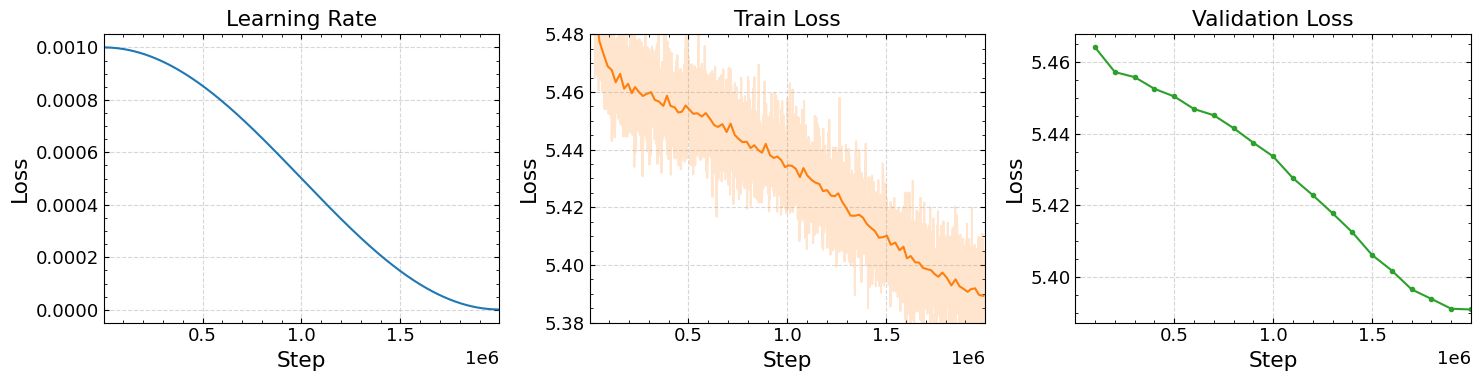

In [ ]:
from namespace import *
from tensorboard.backend.event_processing import event_accumulator

def plot_training(path, train_ylim=(5.38, 5.48), savefig=None, label=None, show_raw=True, ):
    def get_data(ea, tag):
        events = ea.Scalars(tag)
        steps = [e.step for e in events]
        values = [e.value for e in events]
        return steps, values

    steps_lr, lr = [], []
    steps_train_loss, train_loss = [], []
    steps_val_loss, val_loss = [], []

    max_step_lr = 0
    max_step_tr = 0
    max_step_val = 0

    for f in np.atleast_1d(path):
        ea = event_accumulator.EventAccumulator(f)
        ea.Reload()

        s_lr, l = get_data(ea, "Train/LR")
        s_tr, tr = get_data(ea, "Train/Loss")
        s_val, val = get_data(ea, "Val/Loss")

        s_lr = [step + max_step_lr for step in s_lr]
        s_tr = [step + max_step_tr for step in s_tr]
        s_val = [step + max_step_val for step in s_val]

        steps_lr.extend(s_lr)
        lr.extend(l)
        steps_train_loss.extend(s_tr)
        train_loss.extend(tr)
        steps_val_loss.extend(s_val)
        val_loss.extend(val)

        max_step_lr = steps_lr[-1] if steps_lr else 0
        max_step_tr = steps_train_loss[-1] if steps_train_loss else 0
        max_step_val = steps_val_loss[-1] if steps_val_loss else 0

    def sort_and_array(steps, values):
        steps = np.array(steps)
        values = np.array(values)
        idx = np.argsort(steps)
        return steps[idx], values[idx]

    steps_lr, lr = sort_and_array(steps_lr, lr)
    steps_train_loss, train_loss = sort_and_array(steps_train_loss, train_loss)
    steps_val_loss, val_loss = sort_and_array(steps_val_loss, val_loss)
    

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    trunc = min(len(lr), 2000)
    axes[0].plot(reduce(steps_lr, trunc), 
                 reduce(lr, trunc), 
                 label="Learning Rate", color="tab:blue")
    plotter(ax=axes[0], title="Learning Rate", xlabel="Step", ylabel="Loss")

    if show_raw: 
        trunc = min(len(steps_train_loss)-1, 5000)
        axes[1].plot(reduce(steps_train_loss[1:], trunc),
                     reduce(train_loss[1:], trunc),
                     label="Train Loss", color="tab:orange", alpha=0.2)
        
    trunc = min(len(steps_train_loss)-1, 100)
    axes[1].plot(reduce(steps_train_loss[1:], trunc), 
                 reduce(train_loss[1:], trunc),
                 label="Train Loss (smoothed)", color="tab:orange")
    plotter(ax=axes[1], title="Train Loss", xlabel="Step", ylabel="Loss", ylim=train_ylim)

    axes[2].plot(steps_val_loss, val_loss,  
                 label="Val Loss", color="tab:green", marker=".")
    plotter(ax=axes[2], title="Validation Loss", xlabel="Step", ylabel="Loss")

    for ax in axes: 
        plotter(ax=ax, grid=True, xlim=(steps_lr[0], steps_lr[-1]))
    
    plt.tight_layout()
    
    if savefig: 
        fig.savefig(plots_path + savefig)
        print(f"plot saved as {plots_path + savefig}")
    
plot_training(
    "/net/data_ttk/lcordes/TTBar_10m_20e/events.out.tfevents.1747736158.lx3agpu4.physik.rwth-aachen.de.820132.0",
    train_ylim=(5.38, 5.48),
    savefig="training_foundation_ttbar.pdf"
    )


"""tmp = list(walk_dir("", "/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/Linear_Baseline/logs"))
plot_training(
    str(tmp[1]),
    train_ylim=(0.42, 0.55),
    savefig="training_classifier_aachen_linear_baseline.pdf"
    )"""

# tmp = list(walk_dir("", "/net/data_ttk/lcordes/test_heads_and_protocols/TTBar/Linear_Baseline/logs"))
# plot_training(
#     str(tmp[1]),
#     train_ylim=(0.42, 55),
#     savefig="training_classifier_ttbar_linear_baseline.pdf"
#     )

"""tmp = list(walk_dir("", "/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/MaxPool_Scratch/logs"))
plot_training(
    str(tmp[1]),
    train_ylim=(0.5, 0.6),
    # savefig="training_classifier_aachen_linear_baseline.pdf"
    )"""

1273649
1885849.0
plot saved as /home/home3/institut_thp/lcordes/Bachelor_Thesis/code/plots/training_foundation_qcd.pdf


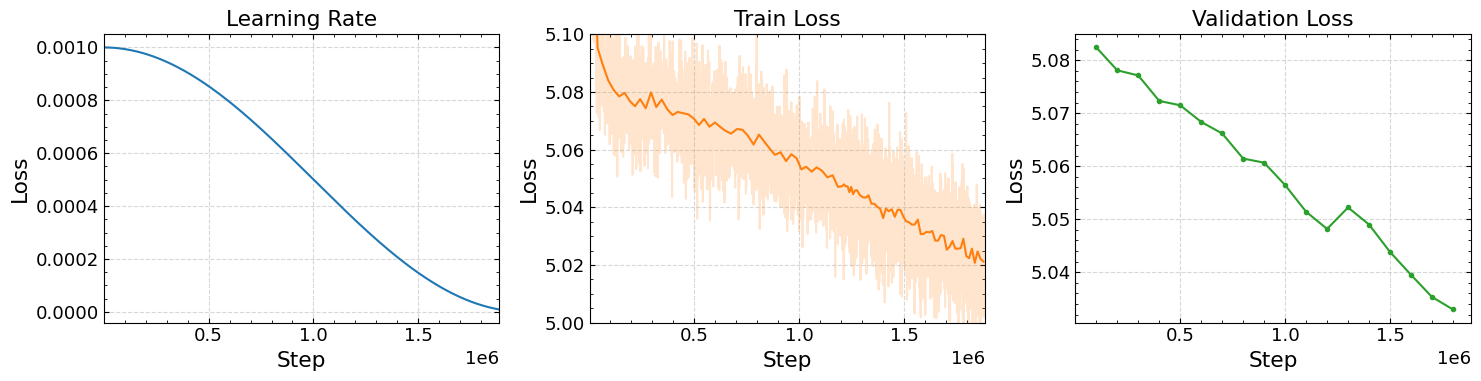

In [ ]:
from namespace import *
from tensorboard.backend.event_processing import event_accumulator

def plot_training(path, train_ylim=(5.38, 5.48), savefig=None, label=None, show_raw=True, ):
    def get_data(ea, tag, s=np.s_[:]):
        events = ea.Scalars(tag)
        steps = [e.step for e in events][s]
        values = [e.value for e in events][s]
        return steps, values

    steps_lr, lr = [], []
    steps_train_loss, train_loss = [], []
    steps_val_loss, val_loss = [], []

    max_step_lr = 0
    max_step_tr = 0
    max_step_val = 0

    for f, glob in zip(np.atleast_1d(path), [0, 1.2e6]):
        ea = event_accumulator.EventAccumulator(f)
        ea.Reload()

        s_lr, l = get_data(ea, "Train/LR",)
        s_tr, tr = get_data(ea, "Train/Loss",)
        s_val, val = get_data(ea, "Val/Loss",)

        # s_lr = [step + max_step_lr for step in s_lr]
        # s_tr = [step + max_step_tr for step in s_tr]
        # s_val = [step + max_step_val for step in s_val]
        
        s_lr = [step + glob for step in s_lr]
        s_tr = [step + glob for step in s_tr]
        s_val = [step + glob for step in s_val]

        steps_lr.extend(s_lr)
        lr.extend(l)
        steps_train_loss.extend(s_tr)
        train_loss.extend(tr)
        steps_val_loss.extend(s_val)
        val_loss.extend(val)

        max_step_lr = steps_lr[-1] if steps_lr else 0
        max_step_tr = steps_train_loss[-1] if steps_train_loss else 0
        max_step_val = steps_val_loss[-1] if steps_val_loss else 0
        print(max_step_lr)

    def sort_and_array(steps, values):
        steps = np.array(steps)
        values = np.array(values)
        idx = np.argsort(steps)
        return steps[idx], values[idx]

    steps_lr, lr = sort_and_array(steps_lr, lr)
    steps_train_loss, train_loss = sort_and_array(steps_train_loss, train_loss)
    steps_val_loss, val_loss = sort_and_array(steps_val_loss, val_loss)
        

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    trunc = min(len(lr), 2000)
    axes[0].plot(reduce(steps_lr, trunc), 
                 reduce(lr, trunc), 
                 label="Learning Rate", color="tab:blue")
    plotter(ax=axes[0], title="Learning Rate", xlabel="Step", ylabel="Loss")

    if show_raw: 
        trunc = min(len(steps_train_loss)-1, 5000)
        axes[1].plot(reduce(steps_train_loss[1:], trunc),
                     reduce(train_loss[1:], trunc),
                     label="Train Loss", color="tab:orange", alpha=0.2)
        
    trunc = min(len(steps_train_loss)-1, 100)
    axes[1].plot(reduce(steps_train_loss[1:], trunc), 
                 reduce(train_loss[1:], trunc),
                 label="Train Loss (smoothed)", color="tab:orange")
    plotter(ax=axes[1], title="Train Loss", xlabel="Step", ylabel="Loss", ylim=train_ylim)

    axes[2].plot(steps_val_loss, val_loss,  
                 label="Val Loss", color="tab:green", marker=".")
    plotter(ax=axes[2], title="Validation Loss", xlabel="Step", ylabel="Loss")

    for ax in axes: 
        plotter(ax=ax, grid=True, xlim=(steps_lr[0], steps_lr[-1]))
    
    plt.tight_layout()
    
    if savefig: 
        fig.savefig(plots_path + savefig)
        print(f"plot saved as {plots_path + savefig}")
    
f = ["/net/data_ttk/lcordes/ZToNuNu_10m_20e/events.out.tfevents.1751630416.lx3agpu3.physik.rwth-aachen.de.225051.0",
     "/net/data_ttk/lcordes/ZToNuNu_10m_20e/events.out.tfevents.1751637178.lx3agpu3.physik.rwth-aachen.de.356991.0",
     "/net/data_ttk/lcordes/ZToNuNu_10m_20e/events.out.tfevents.1751637954.lx3agpu3.physik.rwth-aachen.de.365783.0",
     "/net/data_ttk/lcordes/ZToNuNu_10m_20e/events.out.tfevents.1752009713.lx3agpu3.physik.rwth-aachen.de.1865614.0"
     ]
plot_training(
    f[2:],
    train_ylim=(5, 5.1),
    savefig="training_foundation_qcd.pdf"
    )


In [ ]:
from namespace import * 

def get_metrics(filenames, switch=False, signal_eff=0.3, save=False):
    """ returns aucs, bg_rejection, accuracy, epochs of best model
    """
    shape = np.shape(filenames)
    filenames = np.reshape(filenames, -1)
    
    epochs = []
    pred_files = []    
    for filename in filenames:
        model = torch.load(filename, "cpu")
        epochs.append(model.global_epoch)
        tests_folder = Path(filename).parent / f"tests/{model.global_step}_{model.global_epoch}"
        pred_files.append(select_max(tests_folder, "predictions"))
        
    aucs, bg_rejection, accuracy = [], [], []
    for pred_file in pred_files:
        data = np.load(pred_file)
        preds = (data["predictions"]).flatten()
        labels = data["labels"].flatten().astype(bool) ^ switch 
        accuracy.append(1 - np.abs(np.round(preds) - labels).sum() / len(labels))

        fpr, tpr, _ = sklearn.metrics.roc_curve(labels, preds)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        
        aucs.append(roc_auc)
        bg_rejection.append(1/fpr[np.argmin(np.abs(tpr - signal_eff))])
    
    return [np.reshape(aucs, shape), 
            np.reshape(bg_rejection, shape), 
            np.reshape(accuracy, shape),
            np.reshape(epochs, shape),
            ]

def get_metrics_table(model_dirs, heads, training_procedures, app_to_caption="", filestem=None, signal_eff=0.3):
    """ filenames_ij = model with i-th head and j-th training protocol
        which = 0 | 1 | 2 corresponding to auc | bg_rejection | accuracy
    """
    scale_sigma = lambda x, lamb: u(ev(x), lamb * std(x))
    model_dirs = np.asarray(model_dirs, dtype=object)
    metric_names = {0: "AUCs",
                    1: "Background rejections",
                    2: "Accuracys",
                    3: "Epoch of best models",}
    metric_fmts = {0: ".5f",
                   1: ".1f",
                   2: ".3f",
                   3: ".1f",}
    metric_fmts = {0: None,
                   1: None,
                   2: None,
                   3: None,}
    
    # metrics = get_metrics(model_dirs + "/model_best.pt")
    # metrics = u(metrics, 0)
    metrics = [get_metrics(model_dirs + s + "/model_best.pt", signal_eff=signal_eff) for s in ["", "_2", "_3"]]
    metrics = u(np.average(metrics, axis=0), 
                np.std(metrics, axis=0, ddof=1))
    
    def augment_avg(data):
        data = np.asarray(data)
        res = np.zeros(np.add(data.shape, 1), dtype=object)
        res[:-1, :-1] = data
        res[:-1,  -1] = data.mean(1)
        res[ -1, :-1] = data.mean(0)
        res[ -1,  -1] = 0
        return res
    
    for which in range(4):
        data = augment_avg(metrics[which])
        header = [*heads, "Average"]
        index_column = [*[x.replace("_","") for x in training_procedures], "Average"]
        fmt = None #[None, *([metric_fmts[which]] * (len(heads) + 1))]
        
        table(data=data, 
            headers=header,
            index_column=index_column,
            caption=metric_names[which] + app_to_caption,
            fmt=fmt,
            filename=filestem + f"_{which}.tex" if filestem else None,
            udigits=2)


heads = ["Linear", "MaxPool", "MeanPool", "AttnPool", "CLSToken"]
protocols = ["Scratch", "Baseline", "ReducedLR", "Freeze", "Freeze_Reduced_LR"]

# model_dirs = [["/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/" + i + "_" + j
#               for j in protocols] for i in heads]

# get_metrics_table(model_dirs, heads, protocols,
#                 app_to_caption=r" for Aachen dataset and TTBar backbone", 
#                 filestem=f"Classifier_Aachen_TTBarBackbone")


model_dirs = [["/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/Z_Backbone/" + i + "_" + j
              for j in protocols] for i in heads]

get_metrics_table(model_dirs, heads, protocols,
                app_to_caption=r" for Aachen dataset and QCD backbone",
                signal_eff=0.3)

                              <AUCs for Aachen dataset and QCD backbone>                               
╭─────────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│                 │ Linear      │ MaxPool     │ MeanPool    │ AttnPool    │ CLSToken    │ Average     │
├─────────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ Scratch         │ 0.8593(19)  │ 0.8137(81)  │ 0.8157(89)  │ 0.814(57)   │ 0.8357(37)  │ 0.828(12)   │
│ Baseline        │ 0.87073(19) │ 0.85343(89) │ 0.86709(35) │ 0.86498(16) │ 0.86868(50) │ 0.86498(22) │
│ ReducedLR       │ 0.87165(18) │ 0.85601(52) │ 0.86781(44) │ 0.86691(57) │ 0.87195(28) │ 0.86687(19) │
│ Freeze          │ 0.87069(21) │ 0.790(46)   │ 0.86808(43) │ 0.86581(29) │ 0.86850(84) │ 0.8526(93)  │
│ FreezeReducedLR │ 0.87125(13) │ 0.8567(11)  │ 0.86776(15) │ 0.86625(26) │ 0.87177(20) │ 0.86674(23) │
│ Average         │ 0.86873(39) │ 0.8340(94)  │ 0.8573(18)  │ 0.

/home/home3/institut_thp/lcordes/gpu_env/miniconda/envs/main/lib/python3.9/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [ ]:
def plot_best_scratch_vs_finetune():
    all_models = np.array(list(walk_dir(dir="/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone")))
    idx_scratch = np.array(["Scratch" in str(x) for x in enumerate(all_models)])
    aucs = get_metrics(all_models)[0]
    
    scratch_models = all_models[idx_scratch]
    scratch_aucs = aucs[idx_scratch]
    scratch_best = scratch_models[np.argmax(scratch_aucs)]
    scratch_worst = scratch_models[np.argmin(scratch_aucs)]
    
    other_models = all_models[~idx_scratch]
    other_aucs = aucs[~idx_scratch]
    other_best = other_models[np.argmax(other_aucs)]
    other_worst = other_models[np.argmin(other_aucs)]
    
    preds = []
    for model in [scratch_best, other_best, scratch_worst, other_worst]:
        model = torch.load(model, "cpu")
        pred = select_max(model.dir / "tests" / f"{model.global_step}_{model.global_epoch}",
                           "predictions")
        preds.append(pred)
    print(preds)
    
    plot_classifiers(preds,
                     ["best from-scratch", "best non-scratch", "worst from-scratch", "worst non-scratch"])

# plot_best_scratch_vs_finetune() 

best = select_max_auc("Attn")
pred = select_pred(best)

print(best, pred)


/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/AttnPool_ReducedLR_2/model_best.pt /net/data_ttk/lcordes/test_heads_and_protocols/Aachen/TTBar_Backbone/AttnPool_ReducedLR_2/tests/34983_9/predictions_64784.npz


╭───────┬───────────┬──────────────────────╮
│   Num │   Total/h │   per Classifier/min │
├───────┼───────────┼──────────────────────┤
│   150 │    72.689 │               29.076 │
╰───────┴───────────┴──────────────────────╯


(array([14., 76., 43.,  7.,  4.,  1.,  1.,  1.,  1.,  2.]),
 array([14.61291196, 21.36763044, 28.12234892, 34.87706741, 41.63178589,
        48.38650437, 55.14122286, 61.89594134, 68.65065983, 75.40537831,
        82.16009679]),
 <BarContainer object of 10 artists>)

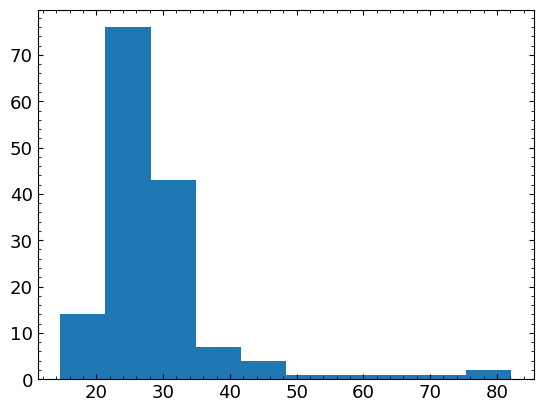

In [122]:
# calculate total training time
dir = "/net/data_ttk/lcordes/test_heads_and_protocols/Aachen/"
train_time = []
test_time = []
for model in walk_dir(r".*model_last\.pt$", dir):
    model = torch.load(model, "cpu")
    train_time.append(model.total_time_trained)
    test_time.append(model.total_time_tested)

total = np.sum(train_time) + np.sum(test_time)
table([len(train_time), total / 60**2, total / len(train_time) / 60],
      ["Num", "Total/h", "per Classifier/min"])

plt.hist(np.divide(train_time, 60))

In [ ]:
info(paths["qcd/train"])
info(paths["aachen/train"])

info(paths["qcd/val"])
info(paths["aachen/val"])

info(paths["qcd/test"])
info(paths["aachen/test"])

                       <info for /net/data_ttk/lcordes/Semi-Visible/qcd/train_qcd_disc.h5 (328.045 MB)>                       
╭─────┬──────────────┬───────────────┬───────────────────────────────────────┬───────────────────────────────────────────────╮
│   i │ keys         │ shape         │ columns                               │ values                                        │
├─────┼──────────────┼───────────────┼───────────────────────────────────────┼───────────────────────────────────────────────┤
│   1 │ /discretized │ (284722, 600) │ PT_0 Eta_0 Phi_0 PT_1 Eta_1 Phi_1 ... │ 24 16 15 24 16 17 ...                         │
│   2 │ /eta_bins    │ (30, 1)       │ 0                                     │ -0.800 -0.745 -0.690 -0.634 -0.579 -0.524 ... │
│   3 │ /phi_bins    │ (30, 1)       │ 0                                     │ -0.800 -0.745 -0.690 -0.634 -0.579 -0.524 ... │
│   4 │ /pt_bins     │ (40, 1)       │ 0                                     │ 0.226 0.272 0.326 0.392 0.471 0.

In [ ]:
from namespace import *

def calc_intersection(p1, p2):
    df1 = pd.read_hdf(p1, "discretized")
    df2 = pd.read_hdf(p2, "discretized")
    intersection = len(pd.merge(df1, df2, how='inner'))
    table([len(df1), len(df2), intersection, intersection/len(df1), intersection/len(df2)],
          ["len df1", "len df2", "intersection", "i / len df1", "i / len df2"],
          caption=f"intersection for {p1.name} and {p2.name}",
          fmt=[".8", ".8", ".8", ".1%", ".1%"])
    
    
calc_intersection(paths["qcd/train"], paths["qcd/val"])
calc_intersection(paths["qcd/train"], paths["qcd/test"])
calc_intersection(paths["qcd/val"], paths["qcd/test"])

calc_intersection(paths["aachen/train"], paths["aachen/val"])
calc_intersection(paths["aachen/train"], paths["aachen/test"])
calc_intersection(paths["aachen/val"], paths["aachen/test"])

"""         
<intersection for train_qcd_disc.h5 and val_qcd_disc.h5>         
╭───────────┬───────────┬────────────────┬───────────────┬───────────────╮
│   len df1 │   len df2 │   intersection │ i / len df1   │ i / len df2   │
├───────────┼───────────┼────────────────┼───────────────┼───────────────┤
│    284722 │     94908 │          52361 │ 18.4%         │ 55.2%         │
╰───────────┴───────────┴────────────────┴───────────────┴───────────────╯
        <intersection for train_qcd_disc.h5 and test_qcd_disc.h5>         
╭───────────┬───────────┬────────────────┬───────────────┬───────────────╮
│   len df1 │   len df2 │   intersection │ i / len df1   │ i / len df2   │
├───────────┼───────────┼────────────────┼───────────────┼───────────────┤
│    284722 │     94908 │          52361 │ 18.4%         │ 55.2%         │
╰───────────┴───────────┴────────────────┴───────────────┴───────────────╯
         <intersection for val_qcd_disc.h5 and test_qcd_disc.h5>          
╭───────────┬───────────┬────────────────┬───────────────┬───────────────╮
│   len df1 │   len df2 │   intersection │ i / len df1   │ i / len df2   │
├───────────┼───────────┼────────────────┼───────────────┼───────────────┤
│     94908 │     94908 │          42549 │ 44.8%         │ 44.8%         │
╰───────────┴───────────┴────────────────┴───────────────┴───────────────╯
      <intersection for train_aachen_disc.h5 and val_aachen_disc.h5>      
╭───────────┬───────────┬────────────────┬───────────────┬───────────────╮
│   len df1 │   len df2 │   intersection │ i / len df1   │ i / len df2   │
├───────────┼───────────┼────────────────┼───────────────┼───────────────┤
│    194350 │     64784 │           7213 │ 3.7%          │ 11.1%         │
╰───────────┴───────────┴────────────────┴───────────────┴───────────────╯
     <intersection for train_aachen_disc.h5 and test_aachen_disc.h5>      
╭───────────┬───────────┬────────────────┬───────────────┬───────────────╮
│   len df1 │   len df2 │   intersection │ i / len df1   │ i / len df2   │
├───────────┼───────────┼────────────────┼───────────────┼───────────────┤
│    194350 │     64784 │           7211 │ 3.7%          │ 11.1%         │
╰───────────┴───────────┴────────────────┴───────────────┴───────────────╯
      <intersection for val_aachen_disc.h5 and test_aachen_disc.h5>       
╭───────────┬───────────┬────────────────┬───────────────┬───────────────╮
│   len df1 │   len df2 │   intersection │ i / len df1   │ i / len df2   │
├───────────┼───────────┼────────────────┼───────────────┼───────────────┤
│     64784 │     64784 │          57621 │ 88.9%         │ 88.9%         │
╰───────────┴───────────┴────────────────┴───────────────┴───────────────╯
"""

         <intersection for train_qcd_disc.h5 and val_qcd_disc.h5>         
╭───────────┬───────────┬────────────────┬───────────────┬───────────────╮
│   len df1 │   len df2 │   intersection │ i / len df1   │ i / len df2   │
├───────────┼───────────┼────────────────┼───────────────┼───────────────┤
│    284722 │     94908 │          52361 │ 18.4%         │ 55.2%         │
╰───────────┴───────────┴────────────────┴───────────────┴───────────────╯
        <intersection for train_qcd_disc.h5 and test_qcd_disc.h5>         
╭───────────┬───────────┬────────────────┬───────────────┬───────────────╮
│   len df1 │   len df2 │   intersection │ i / len df1   │ i / len df2   │
├───────────┼───────────┼────────────────┼───────────────┼───────────────┤
│    284722 │     94908 │          52361 │ 18.4%         │ 55.2%         │
╰───────────┴───────────┴────────────────┴───────────────┴───────────────╯
         <intersection for val_qcd_disc.h5 and test_qcd_disc.h5>          
╭───────────┬───────────┬

' \n     <intersection for train_aachen_disc.h5 and test_aachen_disc.h5>      \n╭───────────┬───────────┬────────────────┬───────────────┬───────────────╮\n│   len df1 │   len df2 │   intersection │ i / len df1   │ i / len df2   │\n├───────────┼───────────┼────────────────┼───────────────┼───────────────┤\n│    194350 │     64784 │           7211 │ 3.7%          │ 11.1%         │\n╰───────────┴───────────┴────────────────┴───────────────┴───────────────╯\n'

### Redo

In [ ]:
# preprocess data
from namespace import * 

preprocess_data(
    "/net/data_ttk/hreyes/Semi-Visible/semivisible-jets/aachen/constitutents/aachen_constit.h5",
    "/net/data_ttk/lcordes/redo/semi-visible/aachen",
    "aachen",
    report=True)

preprocess_data(
    "/net/data_ttk/hreyes/Semi-Visible/semivisible-jets/qcd/constitutents/qcd_constit.h5",
    "/net/data_ttk/lcordes/redo/semi-visible/qcd",
    "qcd",
    report=True)

/.automount/home/home__home3/institut_thp/lcordes/HEP-FoundationModel-Aachen/helpers_lcordes.py:180: RuntimeWarning: invalid value encountered in divide
  eta = 1/2 * np.log((E + p_z) / (E - p_z))



<populating /net/data_ttk/lcordes/redo/semi-visible/aachen, with 251959 jets total>
                    <info for /net/data_ttk/lcordes/redo/semi-visible/aachen/train_aachen.h5 (174.194 MB)>                    
╭─────┬──────────────┬───────────────┬───────────────────────────────────────┬───────────────────────────────────────────────╮
│   i │ keys         │ shape         │ columns                               │ values                                        │
├─────┼──────────────┼───────────────┼───────────────────────────────────────┼───────────────────────────────────────────────┤
│   1 │ /discretized │ (151175, 600) │ PT_0 Eta_0 Phi_0 PT_1 Eta_1 Phi_1 ... │ 29 16 15 27 13 13 ...                         │
│   2 │ /eta_bins    │ (30, 1)       │ 0                                     │ -0.800 -0.745 -0.690 -0.634 -0.579 -0.524 ... │
│   3 │ /phi_bins    │ (30, 1)       │ 0                                     │ -0.800 -0.745 -0.690 -0.634 -0.579 -0.524 ... │
│   4 │ /pt_bins     │ (40

/.automount/home/home__home3/institut_thp/lcordes/HEP-FoundationModel-Aachen/helpers_lcordes.py:180: RuntimeWarning: invalid value encountered in divide
  eta = 1/2 * np.log((E + p_z) / (E - p_z))



<populating /net/data_ttk/lcordes/redo/semi-visible/qcd, with 327269 jets total>
                       <info for /net/data_ttk/lcordes/redo/semi-visible/qcd/train_qcd.h5 (226.250 MB)>                       
╭─────┬──────────────┬───────────────┬───────────────────────────────────────┬───────────────────────────────────────────────╮
│   i │ keys         │ shape         │ columns                               │ values                                        │
├─────┼──────────────┼───────────────┼───────────────────────────────────────┼───────────────────────────────────────────────┤
│   1 │ /discretized │ (196361, 600) │ PT_0 Eta_0 Phi_0 PT_1 Eta_1 Phi_1 ... │ 24 16 15 24 16 17 ...                         │
│   2 │ /eta_bins    │ (30, 1)       │ 0                                     │ -0.800 -0.745 -0.690 -0.634 -0.579 -0.524 ... │
│   3 │ /phi_bins    │ (30, 1)       │ 0                                     │ -0.800 -0.745 -0.690 -0.634 -0.579 -0.524 ... │
│   4 │ /pt_bins     │ (40, 1

In [ ]:
# performance tables

from namespace import * 

def get_metrics(filenames, switch=False, signal_eff=0.3, traintime=False):
    """ returns aucs, bg_rejection, accuracy, epochs of best model
    """
    shape = np.shape(filenames)
    filenames = np.reshape(filenames, -1)
    
    epochs = []
    pred_files = []    
    time_trained = []
    for filename in np.atleast_1d(filenames):
        model = torch.load(filename, "cpu")
        epochs.append(model.global_epoch)
        time_trained.append(model.total_time_trained)
        tests_folder = Path(filename).parent / f"tests/{model.global_step}_{model.global_epoch}"
        pred_files.append(select_max(tests_folder, "predictions"))
        
    aucs, bg_rejection, accuracy = [], [], []
    for pred_file in pred_files:
        data = np.load(pred_file)
        preds = (data["predictions"]).flatten()
        labels = data["labels"].flatten().astype(bool) ^ switch 
        accuracy.append(1 - np.abs(np.round(preds) - labels).sum() / len(labels))

        fpr, tpr, _ = sklearn.metrics.roc_curve(labels, preds)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        
        aucs.append(roc_auc)
        bg_rejection.append(1/fpr[np.argmin(np.abs(tpr - signal_eff))])
    
    result = [np.reshape(aucs, shape), 
              np.reshape(bg_rejection, shape), 
              np.reshape(accuracy, shape),
              np.reshape(epochs, shape)]
    if traintime: result.append(np.reshape(time_trained, shape) / 60)
    return result

def get_metrics_table(model_dirs, heads, training_procedures, app_to_caption="", filestem=None, signal_eff=0.3):
    """ filenames_ij = model with i-th head and j-th training protocol
        which = 0 | 1 | 2 corresponding to auc | bg_rejection | accuracy
    """
    scale_sigma = lambda x, lamb: u(ev(x), lamb * std(x))
    model_dirs = np.asarray(model_dirs, dtype=object)
    metric_names = {0: "AUCs",
                    1: "Background rejections",
                    2: "Accuracys",
                    3: "Epoch of best models"}
    
    metrics = [get_metrics(model_dirs + s + "/model_best.pt", signal_eff=signal_eff) for s in ["_1", "_2", "_3"]]
    metrics = u(np.average(metrics, axis=0), 
                np.std(metrics, axis=0, ddof=1))
    
    def augment_avg(data):
        data = np.asarray(data)
        res = np.zeros(np.add(data.shape, 1), dtype=object)
        res[:-1, :-1] = data
        res[:-1,  -1] = data.mean(1)
        res[ -1, :-1] = data.mean(0)
        res[ -1,  -1] = 0
        return res
    
    for which in range(4):
        data = augment_avg(metrics[which])
        header = [*heads, "Average"]
        index_column = [*[x.replace("_","") for x in training_procedures], "Average"]
        fmt = None #[None, *([metric_fmts[which]] * (len(heads) + 1))]
        
        table(data=data, 
            headers=header,
            index_column=index_column,
            caption=metric_names[which] + app_to_caption,
            fmt=fmt,
            filename=filestem + f"_{which}.tex" if filestem else None,
            udigits=2)

def show_progress(dir, rm_last=True):
    files = list(walk_dir(dir=dir))[:-1 if rm_last else None]
    table([[f.parent.name for f in files], *get_metrics(files, traintime=True)],
          ["Model", "AUCs", "BG Rejection", "Accuracy", "Epoch", "Time Trained"],
          caption=f"Progress in {dir}", sort_by_col=1, reverse_sort=True, index_column=True)

# show_progress("/net/data_ttk/lcordes/redo/classifiers/qcd_backbone")
# show_progress("/net/data_ttk/lcordes/redo/classifiers/ttbar_backbone")

heads = ["Linear", "MaxPool", "MeanPool", "AttnPool", "CLSToken"]
protocols = ["Scratch", "Baseline", "ReducedLR", "Freeze", "Freeze_Reduced_LR"]

models_ttbar = [["/net/data_ttk/lcordes/redo/classifiers/ttbar_backbone/" + i + "_" + j
                  for j in protocols] for i in heads]

models_qcd = [["/net/data_ttk/lcordes/redo/classifiers/qcd_backbone/" + i + "_" + j
                  for j in protocols] for i in heads]

# get_metrics_table(models_ttbar, heads, protocols,
#                 app_to_caption=r" for Classifiers finetuned from the $t\bar t$ backbone",
#                 signal_eff=0.3,
#                 filestem="perf_ttbar_bb")

# get_metrics_table(models_qcd, heads, protocols,
#                 app_to_caption=r" for classifiers finetuned from the \gls{qcd} backbone",
#                 signal_eff=0.3,
#                 filestem="perf_qcd_bb")

                         <AUCs for classifiers finetuned from the qcd backbone>                          
╭─────────────────┬──────────────┬─────────────┬──────────────┬─────────────┬─────────────┬─────────────╮
│                 │ Linear       │ MaxPool     │ MeanPool     │ AttnPool    │ CLSToken    │ Average     │
├─────────────────┼──────────────┼─────────────┼──────────────┼─────────────┼─────────────┼─────────────┤
│ Scratch         │ 0.85754(86)  │ 0.8144(47)  │ 0.8214(25)   │ 0.781(47)   │ 0.8354(39)  │ 0.8219(95)  │
│ Baseline        │ 0.868838(69) │ 0.8520(10)  │ 0.86480(93)  │ 0.86353(12) │ 0.86638(59) │ 0.86312(30) │
│ ReducedLR       │ 0.869807(62) │ 0.8531(17)  │ 0.86585(45)  │ 0.86439(51) │ 0.87033(34) │ 0.86470(37) │
│ Freeze          │ 0.86866(33)  │ 0.76103(92) │ 0.86602(23)  │ 0.86336(50) │ 0.86620(18) │ 0.84505(23) │
│ FreezeReducedLR │ 0.86922(39)  │ 0.85475(30) │ 0.866147(84) │ 0.86456(57) │ 0.87026(90) │ 0.86499(24) │
│ Average         │ 0.86681(20)  │ 0.8271(10) 

/home/home3/institut_thp/lcordes/gpu_env/miniconda/envs/main/lib/python3.9/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [ ]:
from namespace import *

filepath = "/net/data_ttk/hreyes/OneBin/TTBar_train___1Mfromeach_403030.h5" # 10M 
filepath = "/net/data_ttk/hreyes/OneBin/TTBar_val___1Mfromeach_403030.h5" # 800k 
filepath = "/net/data_ttk/hreyes/OneBin/TTBar_test___1Mfromeach_403030.h5" # 2M 
data = pd.read_hdf(filepath, key="discretized",)
data = pd.HDFStore(filepath, mode="r",)
data["discretized"].shape

(2000000, 600)